# Chapter 1 Exploratory Data Analysis

This notebook contains all of our ideas for what should be included in the EDA.

Business Question: 
Which pre-release movie characteristics most strongly drive box-office profitability?

Research Question:
How accurately can machine-learning models predict movie profitability using metadata, cast features, and review-related information?

Sub-Questions:
1) (Iro):  Which pre-release characteristics, especially genre and cast composition, most strongly predict a movie’s profitability?
2) (Rosie):  How do user and critic review patterns and rating metrics values differ between profitable and non-profitable movies?
3) (Jun): Which movie groups perform the highest in regards to box office success, reviews and awards earned?						

**Database / ML Pipeline Flow**

1. Initial data frames
    - df_metaclean -> movie metadata
    - df_sales -> box office and sales data
    - df_exreviews -> expert reviews
    - df_usreviews -> user reviews

2. Master movie table
    - movies_master
- Unified movie table with a single movie_id per movie

3. Key propagation

4. Cleaning, filtering, and aggregation 
    - sales_main -> cleaned sales data (1 row per movie)
    - df_exreviews_filt -> expert reviews before release date
    - exp_summary -> expert review aggregates per movie
    - df_usreviews_filt -> user reviews before release date
    - usr_summary -> user review aggregates per movie
    - movies_master_clean -> cleaned movie metadata
    - movie_panel_full -> fully merged movie-level dataset

5. Normalized tables 
    - genre_table -> movie–genre relationships
    - actor_table -> unique actors
    - cast_table -> movie–actor relationships

6. ML preparation concept
    - movie_panel_full -> storage-level table (not ML-ready)

7. ML feature base
    - movie_fe_base -> clean, numeric movie-level features

8. Transformer text features
    - review_text_df -> expert review text
    - review_emb_df -> review-level embeddings
    - movie_emb_df -> movie-level embeddings
    - X_with_emb -> features + embeddings

9. Feature selection
    - X_pca -> PCA-reduced embedding features

10. Feature transformation
    - X_movies -> scaled and encoded feature matrix

11. Imputation
    - X_movies_imputed -> final ML-ready dataset

In [4]:
import sys
!{sys.executable} -m pip install rapidfuzz

  Using cached rapidfuzz-3.14.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (12 kB)
Using cached rapidfuzz-3.14.3-cp312-cp312-macosx_11_0_arm64.whl (1.4 MB)


In [5]:
#Library Imports --- IGNORE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from rapidfuzz.fuzz import ratio as rapidfuzz_ratio
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from matplotlib.ticker import ScalarFormatter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [21]:
#Reading the files
df_exreviews = pd.read_excel(os.path.join("..", "Metacritic dataset", "ExpertReviews.xlsx"))
df_metaclean = pd.read_excel(os.path.join("..", "Metacritic dataset", "metaClean43Brightspace.xlsx"))
df_sales = pd.read_excel(os.path.join("..", "Metacritic dataset", "sales.xlsx"))
df_usreviews = pd.read_excel(os.path.join("..", "Metacritic dataset", "UserReviews.xlsx"))

In [6]:
# df_metaclean.head(5)

## 1.1 MetaCritic Data Analysis (Jun)

Number of rows to columns: (11364, 13)

Number of missing values in dataset:
url              0 (0.0%)
title            0 (0.0%)
studio         350 (3.1%)
rating        1067 (9.4%)
runtime        255 (2.2%)
cast         3702 (32.6%)
director        14 (0.1%)
genre           20 (0.2%)
summary      5897 (51.9%)
awards       6977 (61.4%)
metascore        0 (0.0%)
userscore    2105 (18.5%)
RelDate          0 (0.0%)
dtype: object


,url,title,studio,rating,runtime,cast,director,genre,summary,awards,metascore,userscore,RelDate
0,https://www.metacritic.com/movie/!women-art-re...,!Women Art Revolution,Hotwire Productions,| Not Rated,83.0,NaN,Lynn Hershman-Leeson,Documentary,NaN,NaN,70,NaN,2011-06-01
1,https://www.metacritic.com/movie/10-cloverfiel...,10 Cloverfield Lane,Paramount Pictures,| PG-13,104.0,"John Gallagher Jr.,John Goodman,Mary Elizabeth...",Dan Trachtenberg,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror","Waking up from a car accident, a young woman (...","#18MostDiscussedMovieof2016 , #1MostSharedMovi...",76,7.7,2016-03-11
2,https://www.metacritic.com/movie/10-items-or-less,10 Items or Less,Click Star,| R,82.0,"Jonah Hill,Morgan Freeman,Paz Vega",Brad Silberling,"Drama,Comedy,Romance",While researching a role as a supermarket mana...,NaN,54,5.8,2006-12-01
3,https://www.metacritic.com/movie/10-years,10 Years,Anchor Bay Entertainment,| R,100.0,"Channing Tatum,Chris Pratt,Jenna Dewan",Jamie Linden,"Drama,Comedy,Romance",NaN,NaN,61,6.9,2012-09-14
4,https://www.metacritic.com/movie/100-bloody-acres,100 Bloody Acres,Music Box Films,| Not Rated,91.0,NaN,Cameron Cairnes,"Horror,Comedy",Reg and Lindsay run an organic fertilizer busi...,NaN,63,7.5,2013-06-28


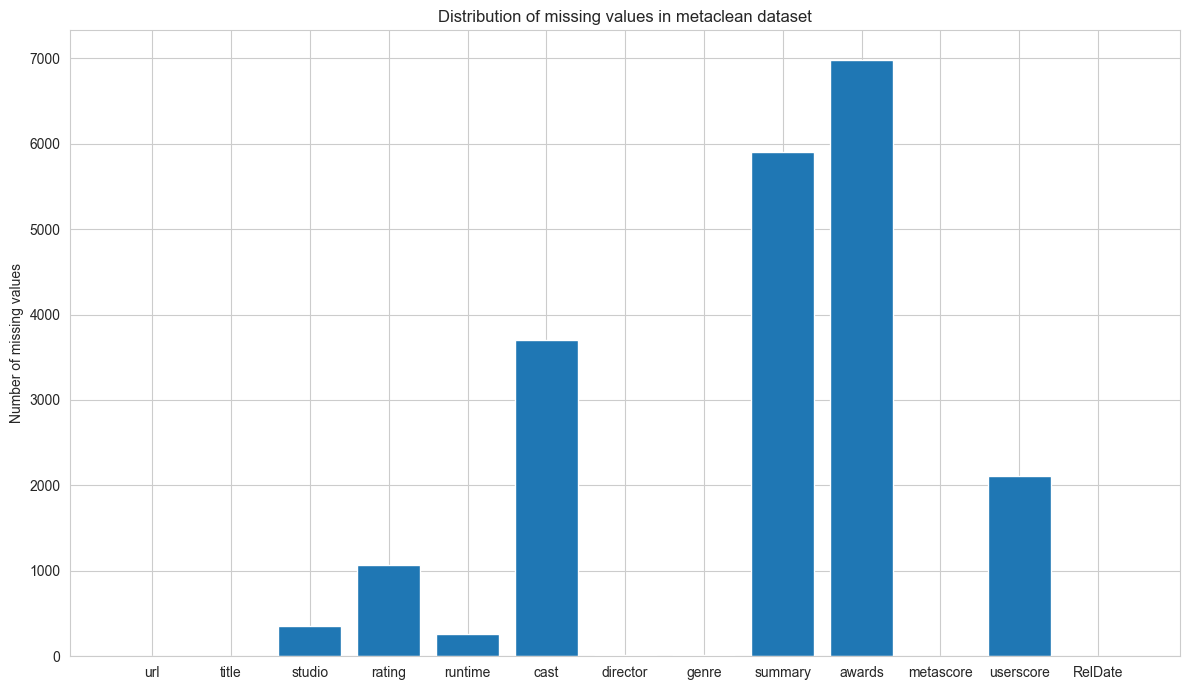

In [23]:
#General number of rows and columns
print("Number of rows to columns:", df_metaclean.shape)
print("")

#Number and percent of missing values
print("Number of missing values in dataset:") 
metaclean_missing_values = df_metaclean.isna().sum()
metaclean_missing_percentage = (df_metaclean.isna().mean() * 100).round(1)
missing_formatted = metaclean_missing_values.astype(str) + " (" + metaclean_missing_percentage.astype(str) + "%)"
print(missing_formatted)

#General shape of dataset
display(df_metaclean.head())

#Plot percentage of missing values per colums
plt.figure(figsize=(12, 7))
plt.bar(metaclean_missing_values.index, metaclean_missing_values)
plt.title("Distribution of missing values in metaclean dataset")
plt.ylabel("Number of missing values")
plt.tight_layout()
plt.show()

In [24]:
#Check for duplicated movies
unique_movie_titles = df_metaclean['title'].dropna().unique()
similar_movie_titles = []

#Threshold for similarity
similarity_threshold = 0.95
n_titles = len(unique_movie_titles)

# Compare each title with every other title
for i in range(n_titles):
    t1 = unique_movie_titles[i]
    for j in range(i + 1, n_titles):
        t2 = unique_movie_titles[j]

        #Filter for length difference
        if abs(len(t1) - len(t2)) > 10:
            continue

        ratio_score = rapidfuzz_ratio(t1, t2) / 100.0
        if ratio_score >= similarity_threshold:
            similar_movie_titles.append((t1, t2, ratio_score))

#Create a dataframe to display similar titles
similar_movie_titles_df = pd.DataFrame(similar_movie_titles, columns=['Title 1', 'Title 2', 'Similarity'])
print(f"Found {len(similar_movie_titles_df)} similar title pairs with similarity >= {similarity_threshold}")
display(similar_movie_titles_df.head(20))

Found 43 similar title pairs with similarity >= 0.95


,Title 1,Title 2,Similarity
0,American Animal,American Animals,0.967742
1,Cheaper by the Dozen,Cheaper by the Dozen 2,0.952381
2,City of God,City of Gold,0.956522
3,Cloudy with a Chance of Meatballs,Cloudy with a Chance of Meatballs 2,0.970588
4,Collateral Damage,Collateral Damages,0.971429
5,Dark Water,Dark Waters,0.952381
6,Deliver Us from Evil,Deliver Us From Evil,0.950000
7,Harry Potter and the Deathly Hallows: Part 2,Harry Potter and the Deathly Hallows: Part I,0.977273
8,Hatchet II,Hatchet III,0.952381
9,Heartbreaker,Heartbreakers,0.960000



===== STUDIO =====
                                         Rarity count  Percentage
studio                                                           
IFC Films                                         408        3.70
Universal Pictures                                345        3.13
Sony Pictures Classics                            344        3.12
Warner Bros. Pictures                             302        2.74
Netflix                                           301        2.73
...                                               ...         ...
Mill Creek Entertainment                            1        0.01
American International Pictures                     1        0.01
Dartmouth Films                                     1        0.01
Fox Lorber Home Video                               1        0.01
20th Century Fox International Classics             1        0.01

[1118 rows x 2 columns]

===== Rare Categories (<1%) =====
                                         Rarity count  Percent

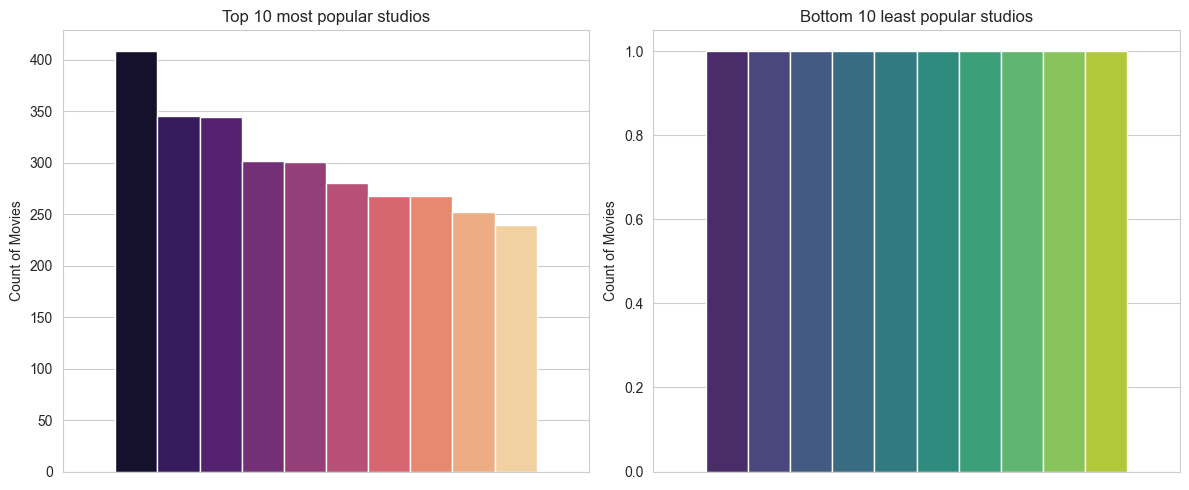

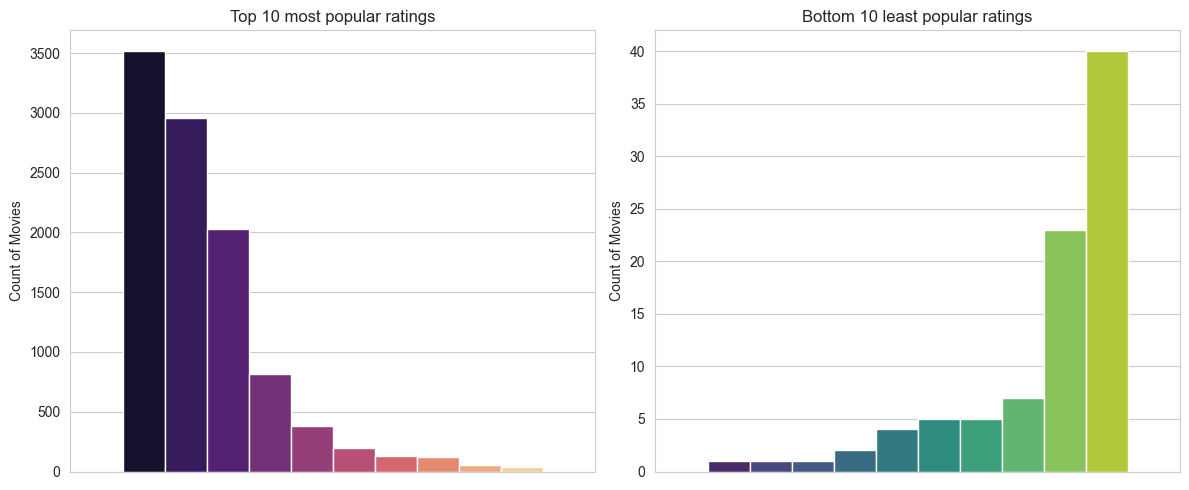

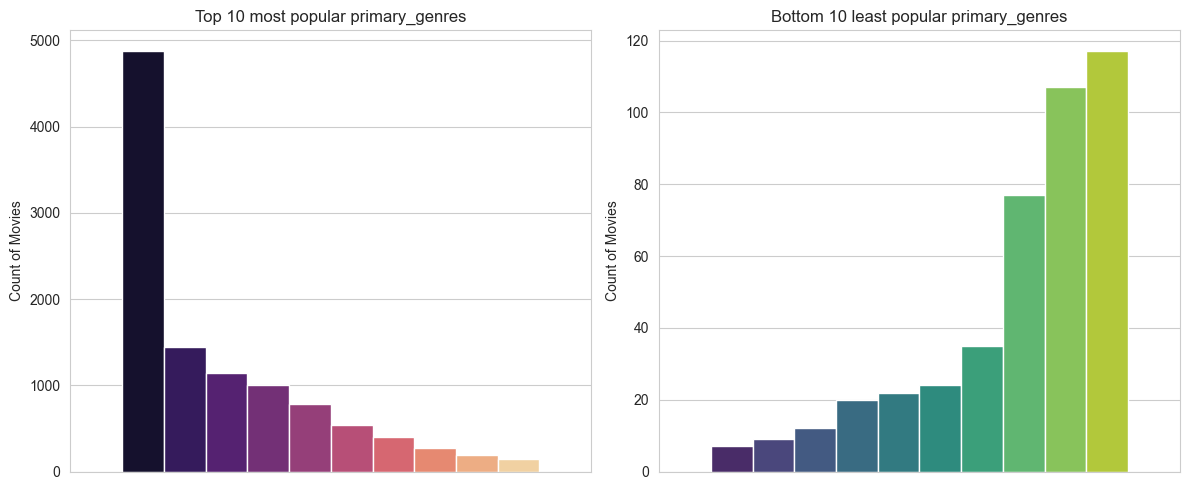

In [25]:
#Check studio, rating and genre for popularity
#Clean genres column
def clean_genre(g):
    if pd.isna(g):
        return np.nan

    #Split based on multiple separators
    parts = re.split(r',|/|\||;| & | - ', g)

    #Strip any whitespaces and remove empty strings
    parts = [p.strip() for p in parts if p.strip() != ""]

    return parts

df_metaclean["clean_genre"] = df_metaclean["genre"].apply(clean_genre)

#Create flat version which contains a single string per movie (based on first genre)
df_metaclean["primary_genre"] = df_metaclean["clean_genre"].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan)

popularity_columns = ["studio", "rating", "primary_genre"]

def rarity_check(df_metaclean, col, rarity_threshold=0.01):
    print(f"\n===== {col.upper()} =====")

    #Popularity counts and percentages
    popularity_count = df_metaclean[col].value_counts(dropna=True)
    popularity_percentage = (
        df_metaclean[col].value_counts(normalize=True, dropna=True) * 100).round(2)

    #Print summary
    popularity_summary = pd.DataFrame({"Rarity count": popularity_count, "Percentage": popularity_percentage})
    print(popularity_summary)

    #Detect rare categories
    rare = popularity_summary[popularity_summary["Percentage"] < (rarity_threshold * 100)]
    print("\n===== Rare Categories (<1%) =====")
    print(rare if not rare.empty else "None")

    return popularity_summary, rare

#Run rarity check again
categorical_profiles = {}
for col in popularity_columns:
    categorical_profiles[col] = rarity_check(df_metaclean, col)

#Visualization for genres, studios and ratings
def plot_top10_bottom10_forall_v2(popularity_summarry, col):
    sns.set_style("whitegrid")
    top10_data = popularity_summarry.nlargest(10, 'Rarity count')
    bottom10_data = popularity_summarry.nsmallest(10, 'Rarity count')

    plt.figure(figsize=(12, 5))

    #Plot for top 10
    plt.subplot(1, 2, 1)
    sns.barplot(hue=top10_data.index, y=top10_data['Rarity count'], palette="magma", legend=False)
    plt.title(f"Top 10 most popular {col}s")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Count of Movies")
    plt.tight_layout()

    #Plot for bottom 10
    plt.subplot(1, 2, 2)
    sns.barplot(hue=bottom10_data.index, y=bottom10_data['Rarity count'], palette="viridis", legend=False)
    plt.title(f"Bottom 10 least popular {col}s")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Count of Movies")
    plt.tight_layout()
    plt.show()

#Generate plots 
for col in popularity_columns:
    popularity_summarry, _ = categorical_profiles[col]
    plot_top10_bottom10_forall_v2(popularity_summarry, col)

,metascore,userscore
count,11364.000000,9259.000000
mean,58.392555,6.542672
std,16.898457,1.374956
min,1.000000,0.200000
25%,47.000000,5.800000
50%,60.000000,6.700000
75%,71.000000,7.500000
max,100.000000,9.700000


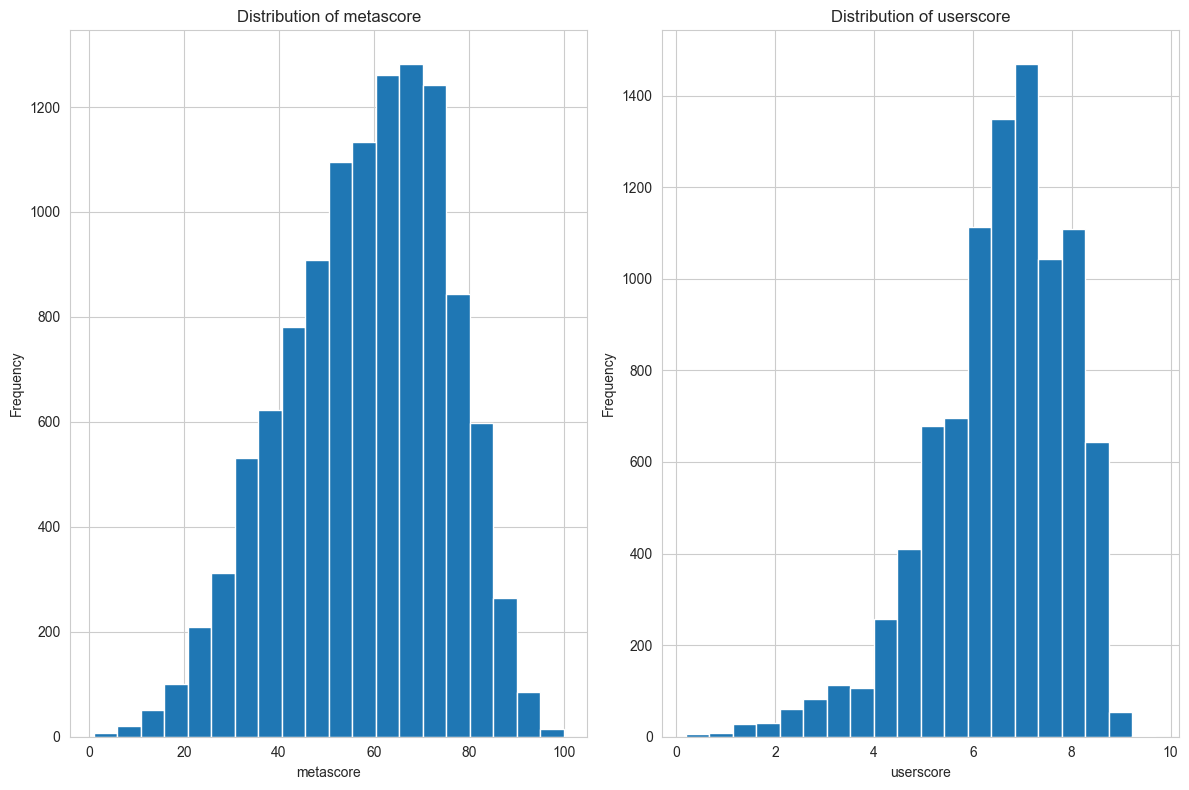

In [26]:
#Distribution of scores
score_columns = ["metascore", "userscore"]
display(df_metaclean[score_columns].describe())

#Plot histogram for meta and userscores
plt.figure(figsize=(12,8))

for i, col in enumerate(["metascore", "userscore"], 1):
    plt.subplot(1, 2, i)
    plt.hist(df_metaclean[col].dropna(), bins=20)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

The exploratory analysis showed that numerical variables such as critic scores and review counts have uneven distributions and very different value ranges. This indicated that feature scaling would be necessary in later preprocessing steps to ensure that no single variable dominates the models due to its scale alone. In addition, correlation analysis suggested that critic scores and review volume capture partially overlapping information. For this reason, both features were retained at this stage, with the intention of applying dimensionality reduction later to reduce redundancy while preserving useful information.

### Conclusion of the Exploratory Data Analysis for MetaClean Data
The MetaClean  dataset contains 13 columns and over 11000 rows, with the cast row containing the most amount of missing data. A similarity check was conducted to check if there were any duplicated movies, however this was unsuccessful. Certain movies which contained multiple genres were split and recategorised based on primary genres. Furthermore, the movies were categorised based on studios, ratings and genres. With the most popular studio being IFC Films producing over 400 movies in the dataset. Other notable figures include the drama genre which accounts for over 40% of the entire dataset.

# 1.2   Expert Reviews Data Analysis (Rosie)

In [27]:
#Shape of the dataset
n_rows, n_cols = df_exreviews.shape
print(f"Number of rows   : {n_rows}")
print(f"Number of columns: {n_cols}")
print(f"Dataset shape   : {df_exreviews.shape}")

#  Missing values (count & percentage)
missing_count = df_exreviews.isna().sum()
missing_percent = (missing_count / n_rows * 100).round(2)

missing_summary = pd.DataFrame({
    "missing_count": missing_count,
    "missing_percent": missing_percent
}).sort_values("missing_count", ascending=False)

print("\nMissing values summary:")
display(missing_summary)

Number of rows   : 238973
Number of columns: 5
Dataset shape   : (238973, 5)

Missing values summary:


,missing_count,missing_percent
idvscore,2,0.0
reviewer,2,0.0
dateP,2,0.0
Rev,2,0.0
url,0,0.0


Cleaned column names: ['url', 'idvscore', 'reviewer', 'datep', 'rev']

After cleaning (sample):


/var/folders/z_/bvymksgn46g5q6bvv50yz5n80000gn/T/ipykernel_37951/1630792300.py:68: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_exreviews["datep"] = pd.to_datetime(dp, errors="coerce")


,url,idvscore,reviewer,datep,rev,datep_clean
0,https://www.metacritic.com/movie/bronson,100.0,andrew o'hehir,NaT,'bronson owes a little or a lot to kubrick s c...,NaN
1,https://www.metacritic.com/movie/bronson,90.0,a.o. scott,NaT,'bronson invites you to admire its protagonist...,NaN
2,https://www.metacritic.com/movie/bronson,90.0,<NA>,NaT,'whether it s peterson/bronson s more theatric...,NaN
3,https://www.metacritic.com/movie/bronson,83.0,noel murray,NaT,'there are two bronsons on display here: the i...,NaN
4,https://www.metacritic.com/movie/bronson,80.0,joshua rothkopf,NaT,'refn has somehow found his way to an authenti...,NaN


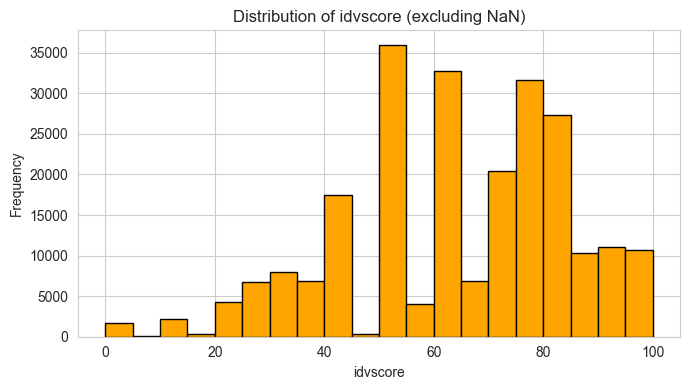

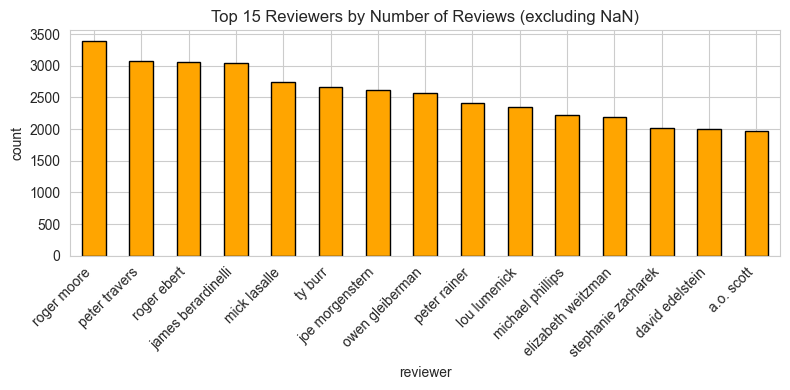

In [28]:
#  Clean column names (multiple separators + whitespace)
df_exreviews.columns = (
    df_exreviews.columns
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace(r"[\/\-\.\s]+", "_", regex=True)   # Replace any sequence of slashes, dashes, dots, or spaces with a single underscore _
    .str.replace(r"[^0-9a-z_]", "", regex=True)     
    .str.replace(r"_+", "_", regex=True)           
    .str.strip("_")                                #Remove underscores from the beginning and the end of the string only
)

print("Cleaned column names:", df_exreviews.columns.tolist())

# replace empty values with NA
_empty_like = ["", " ", "none", "null", "nan", "na", "n/a", "-", "--", "<na>", "<NA>"]

#  Clean URL (lowercase + trim - only keep punctuation like : / .) -keep the format of url
if "url" in df_exreviews.columns:
    df_exreviews["url"] = (
        df_exreviews["url"]
        .astype("string")
        .str.strip()
        .str.lower()
    )
    df_exreviews["url"] = df_exreviews["url"].replace(_empty_like, pd.NA)

# Clean text columns (reviewer, rev): trim, normalize spaces, remove empty 
for col in ["reviewer", "rev"]:
    if col in df_exreviews.columns:
        s = df_exreviews[col]

        # keep true missing as missing
        s = s.astype("string")

        # clean strings
        s = (
            s.str.strip()
            .str.lower()
            .str.replace(r"\s+", " ", regex=True)  # normalize whitespace
        )
        s = s.replace(_empty_like, pd.NA)
        df_exreviews[col] = s

if "reviewer" in df_exreviews.columns:
    df_exreviews["reviewer"] = (
        df_exreviews["reviewer"]
        .str.strip('"')
        .str.strip("'")
    )

#  Clean numeric column (idvscore)
if "idvscore" in df_exreviews.columns:
    df_exreviews["idvscore"] = pd.to_numeric(df_exreviews["idvscore"], errors="coerce")

#  Clean date column differently / YYYY-MM-DD
if "datep" in df_exreviews.columns:
    dp = df_exreviews["datep"]

    dp = dp.astype("string")

    dp = (
        dp.str.strip()
        .str.lower()
        .replace(_empty_like, pd.NA)
    )

    df_exreviews["datep"] = pd.to_datetime(dp, errors="coerce")
    fallback = pd.to_datetime(dp, format="%b %d %Y", errors="coerce")
    df_exreviews["datep"] = df_exreviews["datep"].fillna(fallback)

    df_exreviews["datep_clean"] = df_exreviews["datep"].dt.strftime("%Y-%m-%d")

print("\nAfter cleaning (sample):")
display(df_exreviews.head())

# Popularity: idvscore (distribution) -except Nan 
if "idvscore" in df_exreviews.columns:
    plt.figure(figsize=(7, 4))
    df_exreviews["idvscore"].dropna().plot(kind="hist", bins=20, color="orange", edgecolor="black")
    plt.title("Distribution of idvscore (excluding NaN)")
    plt.xlabel("idvscore")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

#  Popularity: reviewer (top 15) 
if "reviewer" in df_exreviews.columns:
    top_reviewers = df_exreviews["reviewer"].dropna().value_counts().head(15)

    plt.figure(figsize=(8, 4))
    top_reviewers.plot(kind="bar", color="orange", edgecolor="black")
    plt.title("Top 15 Reviewers by Number of Reviews (excluding NaN)")
    plt.xlabel("reviewer")
    plt.ylabel("count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


### Conclusion of Exploratory Data Analysis for Expert Reviews

The Expert Reviews dataset comprises 238,973 rows and five columns: url, idvscore, reviewer, datep, and rev.
The dataset has minimal missing data, with only 2 missing values. Consequently, missing-value visualisation was necessary.
Analysis of duplicate values indicated that duplicate URLs or other column values do not represent redundant information. Reviews linked to the same movie URL exhibit different review scores and texts, and individual reviewers generally assessed different movies. Therefore, duplicate entries were regarded as informative and retained in the dataset.
The distribution of expert review scores (idvscore) is primarily concentrated between 60 and 85, suggesting that most reviewed movies receive moderately positive evaluations. Very low scores are uncommon. Missing (NaN) values were excluded from this analysis to maintain accuracy.
Reviewer popularity was assessed by counting the number of reviews each reviewer received. This analysis excluded missing reviewer names (NaN) to ensure consideration of only valid reviewer contributions.


# 1.3  User Reviews Data Analysis (Rosie)

Number of rows   : 319662
Number of columns: 7
Dataset shape   : (319662, 7)

Missing values summary:


,missing_count,missing_percent
thumbsUp,3580,1.12
thumbsTot,3576,1.12
dateP,3413,1.07
Rev,3413,1.07
reviewer,3407,1.07
idvscore,3404,1.06
url,0,0.00


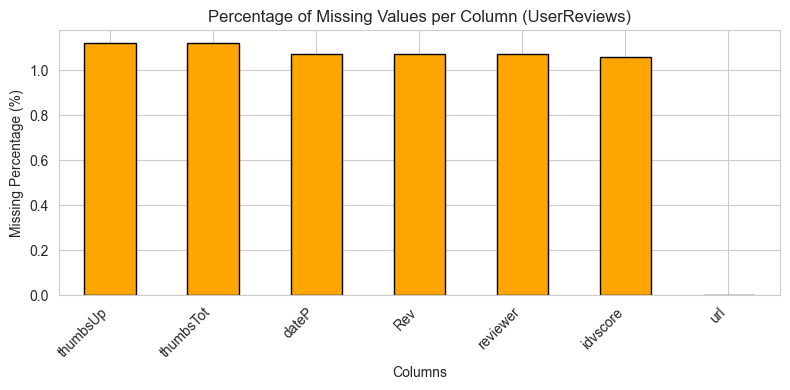

In [29]:

# Number of rows and columns 
n_rows, n_cols = df_usreviews.shape
print(f"Number of rows   : {n_rows}")
print(f"Number of columns: {n_cols}")
print(f"Dataset shape   : {df_usreviews.shape}")

# Missing values: count & percentage
missing_count = df_usreviews.isna().sum()
missing_percent = (missing_count / n_rows * 100).round(2)

missing_summary = (
    pd.DataFrame({
        "missing_count": missing_count,
        "missing_percent": missing_percent
    })
    .sort_values("missing_count", ascending=False)
)

print("\nMissing values summary:")
display(missing_summary)

# Plot missing values 
plt.figure(figsize=(8, 4))
missing_summary["missing_percent"].plot(
    kind="bar",
    color="orange",
    edgecolor="black"
)
plt.title("Percentage of Missing Values per Column (UserReviews)")
plt.ylabel("Missing Percentage (%)")
plt.xlabel("Columns")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [30]:

# Find rows with duplicated URLs
dup_url_rows = df_usreviews[df_usreviews.duplicated(subset=["url"], keep=False)]

print("Number of rows with duplicated URLs:", dup_url_rows.shape[0])


# Group by URL and compare number of rows vs number of unique rows
url_duplicate_check = (
    dup_url_rows
    .groupby("url")
    .apply(lambda g: pd.Series({
        "n_rows": len(g),
        "n_unique_rows": g.drop_duplicates().shape[0]
    }))
    .reset_index()
)

# URLs where all duplicated rows are exactly the same
exact_duplicates = url_duplicate_check[
    (url_duplicate_check["n_rows"] > 1) &
    (url_duplicate_check["n_unique_rows"] == 1)
]

print("\nURLs with EXACT duplicate rows (safe to remove):")
display(exact_duplicates)

#  Show the actual duplicate rows before removal 
if not exact_duplicates.empty:
    print("\nSample of exact duplicate rows:")
    display(
        df_usreviews[df_usreviews["url"].isin(exact_duplicates["url"])]
        .sort_values("url")
        .head(20)
    )
else:
    print("\nNo exact duplicate rows found.")

# Remove exact duplicate rows only
df_usreviews.drop_duplicates(inplace=True)

print("\nShape after removing exact duplicate rows:")
print(df_usreviews.shape)


Number of rows with duplicated URLs: 315812

URLs with EXACT duplicate rows (safe to remove):


/var/folders/z_/bvymksgn46g5q6bvv50yz5n80000gn/T/ipykernel_37951/3291835764.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,url,n_rows,n_unique_rows
5621,https://www.metacritic.com/movie/the-debut,3,1
7210,https://www.metacritic.com/movie/wattstax,2,1



Sample of exact duplicate rows:


,url,idvscore,reviewer,dateP,Rev,thumbsUp,thumbsTot
283645,https://www.metacritic.com/movie/the-debut,10,'TriaF.',"'Mar 16, 2003'","'This is not just an ordinary Filipino film, ...",0,0
283646,https://www.metacritic.com/movie/the-debut,10,'TriaF.',"'Mar 16, 2003'","'This is not just an ordinary Filipino film, ...",0,0
283647,https://www.metacritic.com/movie/the-debut,10,'TriaF.',"'Mar 16, 2003'","'This is not just an ordinary Filipino film, ...",0,0
248470,https://www.metacritic.com/movie/wattstax,6,'[Anonymous]',"'Jun 14, 2003'",'Too many musical performances chopped in hal...,0,0
248471,https://www.metacritic.com/movie/wattstax,6,'[Anonymous]',"'Jun 14, 2003'",'Too many musical performances chopped in hal...,0,0



Shape after removing exact duplicate rows:
(318740, 7)


In [31]:
# =========================
# Clean column names (multiple separators + whitespace)
# =========================
df_usreviews.columns = (
    df_usreviews.columns
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace(r"[\/\-\.\s]+", "_", regex=True)   # multiple separators -> _
    .str.replace(r"[^0-9a-z_]", "", regex=True)     # keep only [a-z0-9_]
    .str.replace(r"_+", "_", regex=True)            # collapse ___ -> _
    .str.strip("_")                                 # remove leading/trailing _
)

print("Cleaned column names:", df_usreviews.columns.tolist())

# =========================
# Replace empty-like values with NA
# =========================
_empty_like = ["", " ", "none", "null", "nan", "na", "n/a", "-", "--", "<na>", "<NA>"]

# =========================
# Clean URL (same logic as previous dataset)
# lowercase + trim, keep : / .
# =========================
if "url" in df_usreviews.columns:
    df_usreviews["url"] = (
        df_usreviews["url"]
        .astype("string")
        .str.strip()
        .str.lower()
        .replace(_empty_like, pd.NA)
    )

# =========================
# Clean text columns (reviewer, rev)
# trim, normalize spaces, remove empty strings
# =========================
for col in ["reviewer", "rev"]:
    if col in df_usreviews.columns:
        s = (
            df_usreviews[col]
            .astype("string")
            .str.strip()
            .str.lower()
            .str.replace(r"\s+", " ", regex=True)
            .replace(_empty_like, pd.NA)
        )

        # remove wrapping quotes in reviewer only
        if col == "reviewer":
            s = s.str.strip('"').str.strip("'")

        df_usreviews[col] = s

# =========================
# Clean numeric columns
# =========================
for col in ["idvscore", "thumbsup", "thumbstot"]:
    if col in df_usreviews.columns:
        df_usreviews[col] = pd.to_numeric(df_usreviews[col], errors="coerce")

# =========================
# Clean date column -> YYYY-MM-DD
# =========================
if "datep" in df_usreviews.columns:
    dp = (
        df_usreviews["datep"]
        .astype("string")
        .str.strip()
        .str.lower()
        .replace(_empty_like, pd.NA)
    )

    # parse dates
    parsed = pd.to_datetime(dp, errors="coerce")

    # fallback for formats like "nov 10 2020"
    fallback = pd.to_datetime(dp, format="%b %d %Y", errors="coerce")
    parsed = parsed.fillna(fallback)

    df_usreviews["datep"] = parsed
    df_usreviews["datep_clean"] = df_usreviews["datep"].dt.strftime("%Y-%m-%d")

print("\nAfter cleaning (sample):")
display(df_usreviews.head())


Cleaned column names: ['url', 'idvscore', 'reviewer', 'datep', 'rev', 'thumbsup', 'thumbstot']


/var/folders/z_/bvymksgn46g5q6bvv50yz5n80000gn/T/ipykernel_37951/1208205405.py:76: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(dp, errors="coerce")



After cleaning (sample):


,url,idvscore,reviewer,datep,rev,thumbsup,thumbstot,datep_clean
0,https://www.metacritic.com/movie/bronson,8.0,longbottom94,2013-04-25,'many have dismissed this film for not explori...,2.0,2.0,2013-04-25
1,https://www.metacritic.com/movie/bronson,9.0,martinb,2009-10-13,'anyone who doesn t like this movie simply jus...,0.0,1.0,2009-10-13
2,https://www.metacritic.com/movie/bronson,10.0,jaakko,2012-07-19,'not sure what to think at this film at first....,1.0,1.0,2012-07-19
3,https://www.metacritic.com/movie/bronson,6.0,capor,2009-10-13,'nicely portrayed but it lacks the elements to...,0.0,1.0,2009-10-13
4,https://www.metacritic.com/movie/bronson,8.0,orwellb.,2009-10-10,'bronson is more than entertainment. it is art...,0.0,0.0,2009-10-10


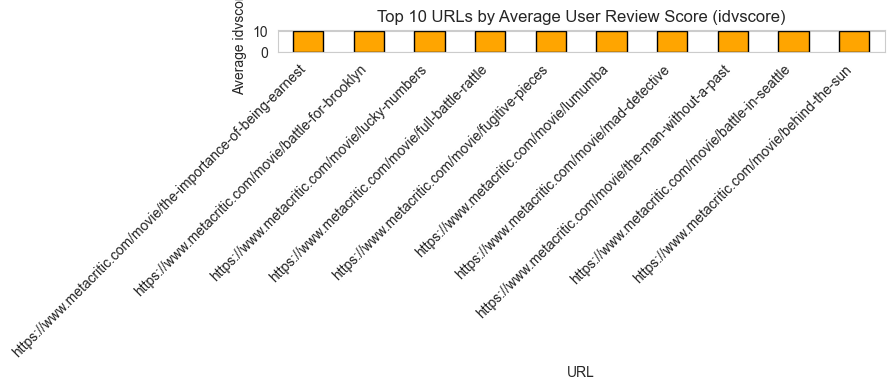

/var/folders/z_/bvymksgn46g5q6bvv50yz5n80000gn/T/ipykernel_37951/3574802628.py:52: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


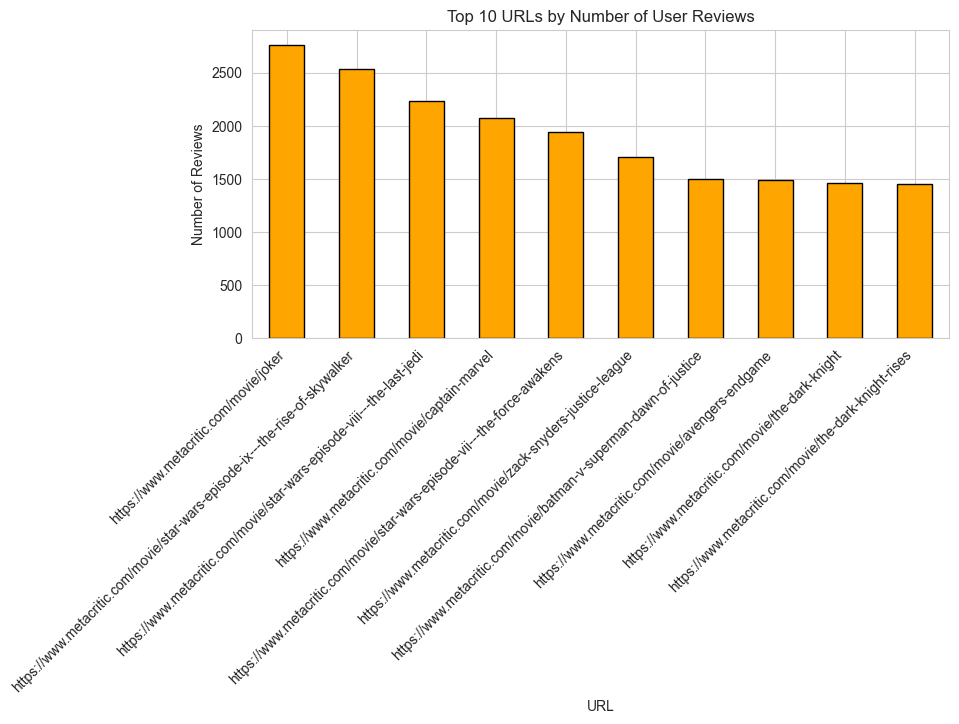

In [32]:
# =========================
# Popularity per URL (excluding NaN)
# Dataset: df_usreviews
# =========================

# --- Popularity of idvscore per URL (average score) ---
if "url" in df_usreviews.columns and "idvscore" in df_usreviews.columns:
    idvscore_per_url = (
        df_usreviews
        .dropna(subset=["idvscore"])
        .groupby("url")["idvscore"]
        .mean()
        .sort_values(ascending=False)
        .head(10)   # top 10 URLs by average score
    )

    plt.figure(figsize=(9, 4))
    idvscore_per_url.plot(
        kind="bar",
        color="orange",
        edgecolor="black"
    )
    plt.title("Top 10 URLs by Average User Review Score (idvscore)")
    plt.xlabel("URL")
    plt.ylabel("Average idvscore")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# --- Popularity of reviewer per URL (number of reviews per URL) ---
if "url" in df_usreviews.columns and "reviewer" in df_usreviews.columns:
    reviewer_per_url = (
        df_usreviews
        .dropna(subset=["reviewer"])
        .groupby("url")["reviewer"]
        .count()
        .sort_values(ascending=False)
        .head(10)   # top 10 most-reviewed URLs
    )

    plt.figure(figsize=(9, 4))
    reviewer_per_url.plot(
        kind="bar",
        color="orange",
        edgecolor="black"
    )
    plt.title("Top 10 URLs by Number of User Reviews")
    plt.xlabel("URL")
    plt.ylabel("Number of Reviews")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


Conclusion of Exploratory Data Analysis

The User Reviews dataset consists of 319,662 rows and five columns: ['url', 'idvscore', 'reviewer', 'dateP', 'Rev', 'thumbsUp', 'thumbsTot']. Missing values are minimal, with approximately 1% per column, indicating a high degree of data completeness. The 'url' column contains no missing data. Duplicate URLs are infrequent, and rows with duplicate values were removed to ensure data integrity. Analysis at the movie URL level reveals distinct differences between user engagement and user rating quality. The first plot identifies the top 10 most-reviewed movies, demonstrating that popular franchise titles such as Joker,Star Wars and Captain marvel receive the highest volume of user reviews. This pattern suggests that well-known franchises generate greater user participation, likely due to broader audience reach and increased public interest.
In contrast, the second plot presents the top 10 movies by average user review score (idvscore), highlighting a different set of titles. These films achieve high average ratings despite receiving relatively few reviews. This finding indicates that high user satisfaction does not necessarily correlate with high review volume. Smaller or less mainstream films may receive fewer reviews but are rated more positively by their audiences.


Overall, user review distributions exhibit higher variance and sentiment diversity compared to expert reviews, justifying their inclusion as a complementary signal to critic scores. This motivated the later use of transformer-based embeddings to capture semantic information beyond numeric aggregates.

# 1.4. Sales Data Analysis (Iro)

In [33]:
# clean column names 
df_sales.columns = (
    df_sales.columns
    .str.lower()
    .str.strip()
    .str.replace(" ", "_") 
    .str.replace(r"[^0-9a-z_]", "", regex=True)
)
df_sales.columns

Index(['year', 'release_date', 'title', 'genre', 'international_box_office',
       'domestic_box_office', 'worldwide_box_office', 'production_budget',
       'unnamed_8', 'opening_weekend', 'theatre_count', 'avg_run_per_theatre',
       'runtime', 'keywords', 'creative_type', 'url'],
      dtype='object')

In [34]:
# clean text column 
text_cols = ["title", "genre", "keywords", "creative_type", "url"]

for col in text_cols:
    if col in df_sales.columns:
        df_sales[col] = (
            df_sales[col].astype(str) # convert to string
            .str.lower()
            .str.strip() # remove leading/trailing spaces
        )

In [35]:
# clean release_date and convert to YYYY-MM-DD 
df_sales["release_date_standard"] = (
    df_sales["release_date"]
        .astype(str)
        .str.replace(r"(st|nd|rd|th)", "", regex=True)        # remove suffixes
        .str.cat(df_sales["year"].astype(str), sep=" ")       # add year
        .pipe(pd.to_datetime, errors="coerce")                # convert to datetime
        .dt.strftime("%Y-%m-%d")                              # final format
)

In [36]:
# convert numeric columns
num_cols = [
    "domestic_box_office", "international_box_office", "worldwide_box_office",
    "production_budget", "opening_weekend", "theatre_count",
    "avg_run_per_theatre", "runtime", "year"
]

for col in num_cols:
    if col in df_sales.columns:
        df_sales[col] = pd.to_numeric(df_sales[col], errors="coerce")

In [37]:
# number of rows and columns
print("Number of rows to columns:", df_sales.shape)
print("")
# missing value summary
df_sales.isna().sum() # how many missing values each column has

Number of rows to columns: (30612, 17)



year                            0
release_date                    0
title                           0
genre                           0
international_box_office     9037
domestic_box_office         18728
worldwide_box_office         9037
production_budget           26132
unnamed_8                   30612
opening_weekend             19683
theatre_count               19649
avg_run_per_theatre         19660
runtime                      6053
keywords                        0
creative_type                   0
url                             0
release_date_standard        2492
dtype: int64

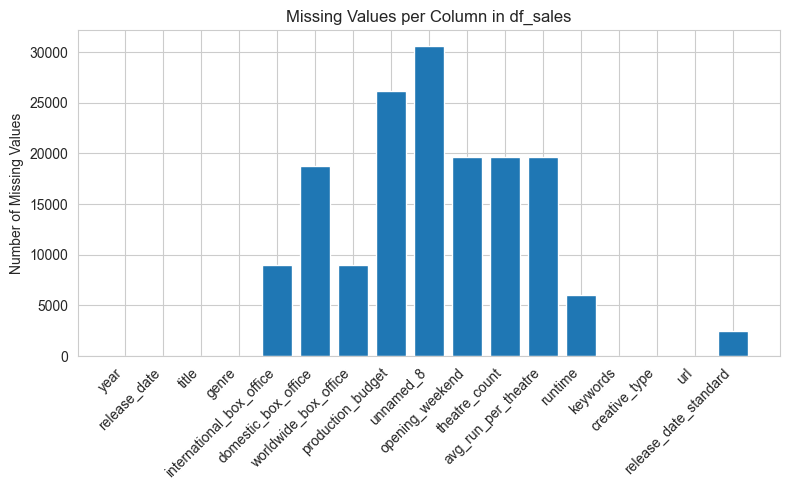

In [38]:
# missing values for each column
missing_values = df_sales.isna().sum()

plt.figure(figsize=(8, 5))
plt.bar(missing_values.index, missing_values)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Missing Values")
plt.title("Missing Values per Column in df_sales")
plt.tight_layout()
plt.show()

**Data Quality Overview**

The dataset contains 30,612 rows and 16 columns. Several fields exhibit substantial missingness, which affects their analytical usefulness:
- production_budget: 26,132 missing entries
- domestic_box_office: 18,728 missing entries
- international_box_office: 9,037 missing entries
- unnamed_8: 30,612 missing entries (entire column missing)

These variables will require either imputation, removal, or external data enrichment depending on the analytical objectives.

Columns with High Usability
- Several key descriptive fields are fully complete:
- year, title, genre: 0 missing values

Other fields have moderate missingness but remain potentially usable with appropriate handling:
runtime: 6,053 missing values (≈20% of records)

In [39]:
# display(df_sales.head())

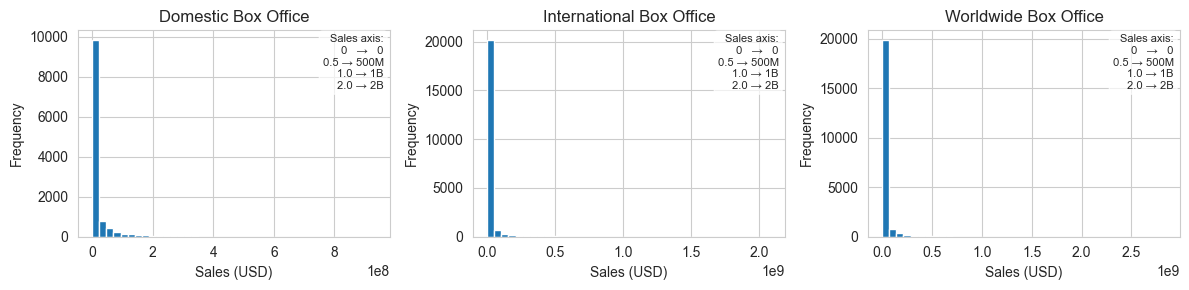

In [40]:
# plot sales distributions
cols = ["domestic_box_office", "international_box_office", "worldwide_box_office"]
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

notation = (
    "Sales axis:\n"
    "0   →   0\n"
    "0.5 → 500M\n"
    "1.0 → 1B\n"
    "2.0 → 2B"
)

for ax, col in zip(axes, cols):
    if col in df_sales.columns:
        _ = ax.hist(df_sales[col].dropna(), bins=40)
        _ = ax.set_title(col.replace("_", " ").title())
        _ = ax.set_xlabel("Sales (USD)")
        _ = ax.set_ylabel("Frequency")

        # suppress printed return value
        _ = ax.text(
            0.98, 0.98,
            notation,
            transform=ax.transAxes,
            fontsize=8,
            ha='right',
            va='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
        )

plt.tight_layout()
plt.show()


**Interpretation of the Box Office Histograms**

The three histograms (Domestic, International, and Worldwide Box Office) show how movie revenues are distributed.
- The x-axis represents sales in USD, but very large values are shown in compressed scientific notation. The legend explains that values like 0.5, 1.0, 2.0 actually correspond to 500M, 1B, and 2B USD.
- The y-axis, labeled Frequency, indicates how many movies fall into each revenue range (bin). A higher bar means more movies in that sales interval.

Across all three charts, the very tall bar near zero shows that most movies earn very little revenue, while only a small number reach hundreds of millions or billions. This creates a long right tail, indicating that box office revenues are extremely skewed, with many low-earning films and a few very high-earning blockbusters.

/var/folders/z_/bvymksgn46g5q6bvv50yz5n80000gn/T/ipykernel_37951/2488680270.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/z_/bvymksgn46g5q6bvv50yz5n80000gn/T/ipykernel_37951/2488680270.py:20: UserWarning: 
The palette list has fewer values (4) than needed (16) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


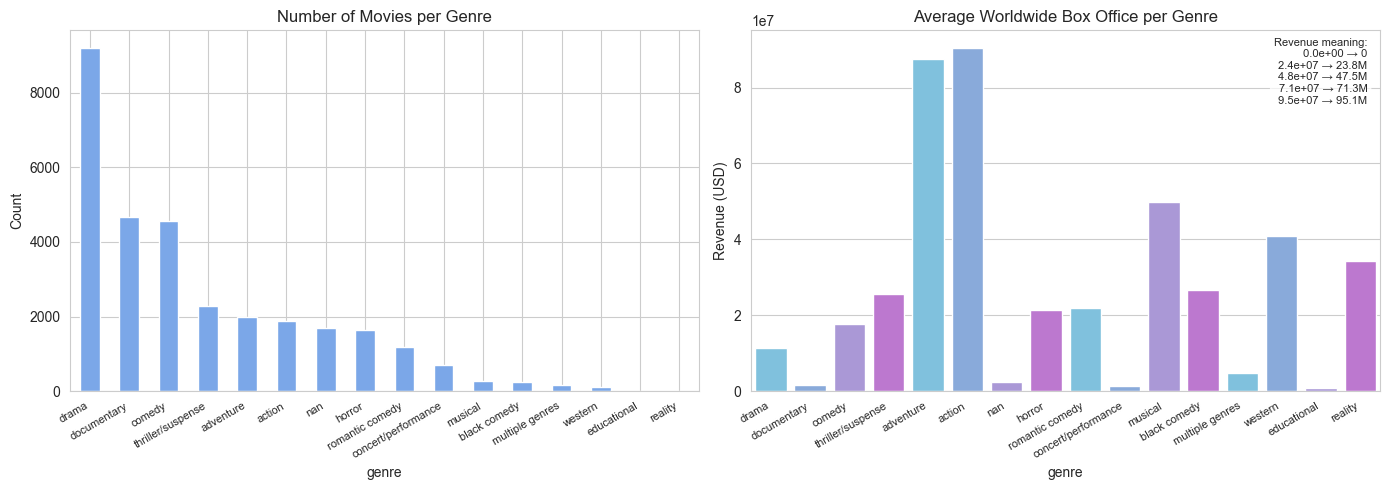

In [41]:
genre_counts = df_sales['genre'].value_counts()  # number of movies per genre

# align sales to the same genre order as counts
genre_sales = (
    df_sales.groupby('genre')['worldwide_box_office']
    .mean()
    .reindex(genre_counts.index)
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
palette = ["#71C7EC", "#7BA7E8", "#A68DE1", "#C46ADD"]

# genre counts 
genre_counts.plot(kind='bar', ax=axes[0], color="#7BA7E8")
axes[0].set_title("Number of Movies per Genre")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("genre")

# average sales per genre 
sns.barplot(
    x=genre_sales.index,
    y=genre_sales.values,
    palette=palette,
    ax=axes[1]
)
axes[1].set_title("Average Worldwide Box Office per Genre")
axes[1].set_ylabel("Revenue (USD)")
axes[1].set_xlabel("genre")

# x-label formatting: rotate + right-align + smaller font
for ax in axes:
    ax.tick_params(axis='x', labelrotation=30, labelsize=8)
    for label in ax.get_xticklabels():
        label.set_ha('right')

# dynamic notation based on y-axis (
ymin, ymax = axes[1].get_ylim()

def human_format(num):
    if num >= 1_000_000_000:
        return f"{num/1e9:.1f}B"
    if num >= 1_000_000:
        return f"{num/1e6:.1f}M"
    return f"{num:.0f}"

notation = (
    "Revenue meaning:\n"
    f"{ymin:.1e} → {human_format(ymin)}\n"
    f"{(ymax*0.25):.1e} → {human_format(ymax*0.25)}\n"
    f"{(ymax*0.50):.1e} → {human_format(ymax*0.50)}\n"
    f"{(ymax*0.75):.1e} → {human_format(ymax*0.75)}\n"
    f"{ymax:.1e} → {human_format(ymax)}"
)

axes[1].text(
    0.98, 0.98,
    notation,
    transform=axes[1].transAxes,
    fontsize=8,
    ha='right',
    va='top',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)

plt.tight_layout()
plt.show()


Genre Summary: 

- Drama is the most produced genre, but earns low average revenue.
- Action and adventure earn the highest revenues (≈$90M+).
- Musical and reality have few films but high revenue.
- Documentary, drama, and educational genres show very low earnings.
- High production volume does not correlate with high revenue.

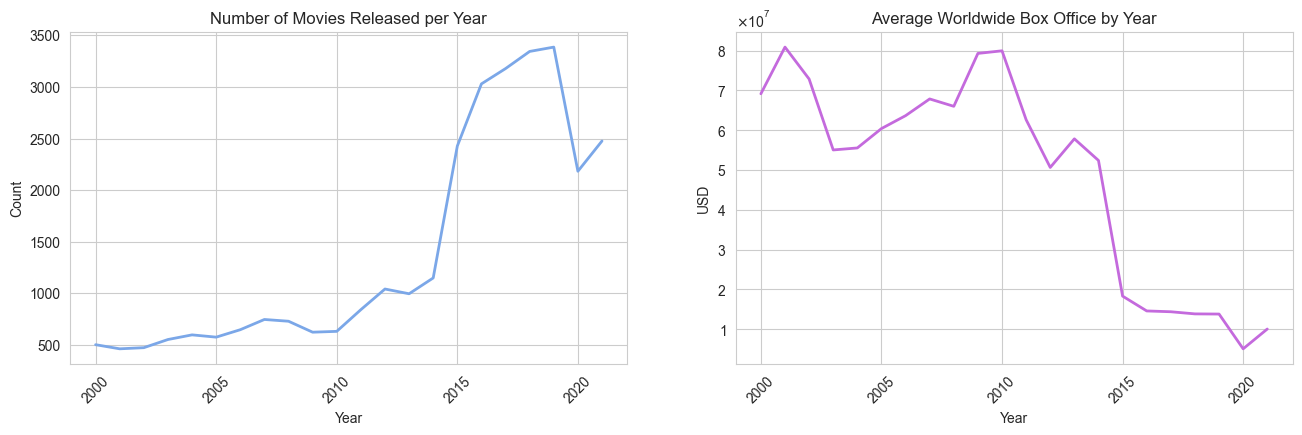

In [ ]:
year_counts = df_sales['year'].value_counts().sort_index()
year_avg_sales = df_sales.groupby('year')['worldwide_box_office'].mean()

palette = ["#71C7EC", "#7BA7E8", "#A68DE1", "#C46ADD"]

# merged plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plt.tight_layout(pad=5)

# number of movies released per year
axes[0].plot(year_counts.index, year_counts.values, color=palette[1], linewidth=2)
axes[0].set_title("Number of Movies Released per Year")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=45)

# average worldwide box office per year
axes[1].plot(year_avg_sales.index, year_avg_sales.values, color=palette[3], linewidth=2)
axes[1].set_title("Average Worldwide Box Office by Year")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("USD")
axes[1].tick_params(axis="x", rotation=45)

# notation
axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axes[1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.show()


Yearly Trends:

- Movies released increased sharply from 2000 to 2018, peaking at ~3,400 films.
- Production dropped in 2019–2020, likely due to global disruptions.
- Average box office peaked around 2001 and 2010, then declined steadily after 2013.
- Recent years show many more movies but much lower revenue per film.

# 1.5 Data Integration (Iro)

## 1.5.1. Helper function creation

Define three utility functions to standardize key movie identifiers:
- extract_url_slug() → isolates the comparable part of each URL
- normalize_title() → cleans and standardizes movie titles
- make_movie_id() → generates a unique, stable movie identifier

A consistent system for matching movies across all datasets, even when URLs differ, titles vary, or remakes exist.

In [43]:
# extract last part of URL to use as slug
def extract_url_slug(url):
    if pd.isna(url):
        return np.nan
    url = str(url)
    url = url.split('?')[0].split('#')[0]
    slug = url.strip('/').split('/')[-1].lower()
    slug = re.sub(r'[^a-z0-9\-]+', '-', slug)
    slug = re.sub(r'-+', '-', slug).strip('-')
    return slug or np.nan

# normalize title for matching
STOP_WORDS = {"the", "a", "an"}

def normalize_title(title):
    if pd.isna(title):
        return np.nan
    t = re.sub(r'[^\w\s]', ' ', str(title).lower())
    words = t.split()
    if words and words[0] in STOP_WORDS:
        words = words[1:]
    return " ".join(words) or np.nan

# movie_key + SERIAL MOVIE ID  

def build_movie_key(df: pd.DataFrame) -> pd.Series:
    """
    One logical key per movie: normalized_title + release_year.
    Same movie across datasets => same movie_key.
    """
    return (
        df["normalized_title"].fillna("").astype(str)
        + "||" +
        df["release_year"].fillna(0).astype(int).astype(str)
    )

serial_counter = {"count": 0}

def generate_serial_id():
    serial_counter["count"] += 1
    return f"MOV{serial_counter['count']:05d}"  # MOV00001, MOV00002, ...

def make_movie_id(movie_key):
    """
    Turn a movie_key into a serial movie_id.
    Called later in the master table, once per unique movie_key.
    """
    if pd.isna(movie_key) or movie_key == "":
        return np.nan
    return generate_serial_id()

## 1.5.2. Update Metaclean data

Extract URL slug, normalize title, get release year, and assign movie_id for Metaclean movies.
Metaclean movies now have clean identifiers and are ready to join.

In [44]:
df_metaclean = df_metaclean.copy()

# URL slug
df_metaclean["url_slug"] = df_metaclean["url"].apply(extract_url_slug)

# Normalized title
df_metaclean["normalized_title"] = df_metaclean["title"].apply(normalize_title)

# Parse RelDate to datetime and extract year
df_metaclean["RelDate_parsed"] = pd.to_datetime(df_metaclean["RelDate"], errors="coerce")
df_metaclean["release_year"] = df_metaclean["RelDate_parsed"].dt.year

# NEW: movie_key (no movie_id yet)
df_metaclean["movie_key"] = build_movie_key(df_metaclean)

df_metaclean.head()


,url,title,studio,rating,runtime,cast,director,genre,summary,awards,metascore,userscore,RelDate,clean_genre,primary_genre,url_slug,normalized_title,RelDate_parsed,release_year,movie_key
0,https://www.metacritic.com/movie/!women-art-re...,!Women Art Revolution,Hotwire Productions,| Not Rated,83.0,NaN,Lynn Hershman-Leeson,Documentary,NaN,NaN,70,NaN,2011-06-01,[Documentary],Documentary,women-art-revolution,women art revolution,2011-06-01,2011,women art revolution||2011
1,https://www.metacritic.com/movie/10-cloverfiel...,10 Cloverfield Lane,Paramount Pictures,| PG-13,104.0,"John Gallagher Jr.,John Goodman,Mary Elizabeth...",Dan Trachtenberg,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror","Waking up from a car accident, a young woman (...","#18MostDiscussedMovieof2016 , #1MostSharedMovi...",76,7.7,2016-03-11,"[Action, Sci-Fi, Drama, Mystery, Thriller, Hor...",Action,10-cloverfield-lane,10 cloverfield lane,2016-03-11,2016,10 cloverfield lane||2016
2,https://www.metacritic.com/movie/10-items-or-less,10 Items or Less,Click Star,| R,82.0,"Jonah Hill,Morgan Freeman,Paz Vega",Brad Silberling,"Drama,Comedy,Romance",While researching a role as a supermarket mana...,NaN,54,5.8,2006-12-01,"[Drama, Comedy, Romance]",Drama,10-items-or-less,10 items or less,2006-12-01,2006,10 items or less||2006
3,https://www.metacritic.com/movie/10-years,10 Years,Anchor Bay Entertainment,| R,100.0,"Channing Tatum,Chris Pratt,Jenna Dewan",Jamie Linden,"Drama,Comedy,Romance",NaN,NaN,61,6.9,2012-09-14,"[Drama, Comedy, Romance]",Drama,10-years,10 years,2012-09-14,2012,10 years||2012
4,https://www.metacritic.com/movie/100-bloody-acres,100 Bloody Acres,Music Box Films,| Not Rated,91.0,NaN,Cameron Cairnes,"Horror,Comedy",Reg and Lindsay run an organic fertilizer busi...,NaN,63,7.5,2013-06-28,"[Horror, Comedy]",Horror,100-bloody-acres,100 bloody acres,2013-06-28,2013,100 bloody acres||2013


## 1.5.3. Update Sales 

Extract URL slug, normalize title, use Sales year, and assign movie_id for Sales movies.

Sales data follows the same ID system and can be merged with Metaclean.

In [45]:
df_sales = df_sales.copy()

# URL slug
df_sales["url_slug"] = df_sales["url"].apply(extract_url_slug)

# Normalized title
df_sales["normalized_title"] = df_sales["title"].apply(normalize_title)

# Use 'year' column as release_year
df_sales["release_year"] = df_sales["year"]

# NEW: movie_key (no movie_id yet)
df_sales["movie_key"] = build_movie_key(df_sales)

df_sales.head()


,year,release_date,title,genre,international_box_office,domestic_box_office,worldwide_box_office,production_budget,unnamed_8,opening_weekend,...,avg_run_per_theatre,runtime,keywords,creative_type,url,release_date_standard,url_slug,normalized_title,release_year,movie_key
0,2000,January 1st,bakha satang,drama,76576.0,NaN,76576.0,NaN,NaN,NaN,...,NaN,129.0,nan,contemporary fiction,https://www.the-numbers.com/movie/bakha-satang...,2000-01-01,bakha-satang-s-korea,bakha satang,2000,bakha satang||2000
1,2001,January 12th,antitrust,thriller/suspense,6900000.0,10965209.0,17865209.0,30000000.0,NaN,5486209.0,...,3.1,NaN,nan,contemporary fiction,https://www.the-numbers.com/movie/antitrust,2001-01-12,antitrust,antitrust,2001,antitrust||2001
2,2000,January 28th,santitos,nan,NaN,378562.0,NaN,NaN,NaN,NaN,...,NaN,105.0,nan,nan,https://www.the-numbers.com/movie/santitos,2000-01-28,santitos,santitos,2000,santitos||2000
3,2002,2002 (Wide) by,frank mcklusky c.i.,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nan,nan,https://www.the-numbers.com/movie/frank-mcklus...,NaN,frank-mcklusky-c-i,frank mcklusky c i,2002,frank mcklusky c i||2002
4,2002,January 25th,a walk to remember,drama,4833792.0,41227069.0,46060861.0,11000000.0,NaN,12177488.0,...,5.3,NaN,coming of age,contemporary fiction,https://www.the-numbers.com/movie/walk-to-reme...,2002-01-25,walk-to-remember-a,walk to remember,2002,walk to remember||2002


Now Sales has the same movie_key as Metaclean for the same title+year.

## 1.5.4. Build the master movie table

Combine Metaclean and Sales movies, remove duplicates, and form one master list.

A unified movies_master table with one consistent movie_id per movie.

In [65]:
# build the master movie table (with movie_key + source_label) 
# define desired columns from each dataset
meta_wanted = [
    "movie_key", "url", "url_slug", "title", "normalized_title",
    "release_year", "RelDate", "runtime", "studio", "genre", "director",
    "cast", "primary_genre", "rating"
]

sales_wanted = [
    "movie_key", "url", "url_slug", "title", "normalized_title",
    "release_year", "release_date", "runtime", "genre", "studio"
]

# keep only existing columns
meta_cols = [c for c in meta_wanted if c in df_metaclean.columns]
sales_cols = [c for c in sales_wanted if c in df_sales.columns]

# build movie tables with source labels
meta_movies = df_metaclean[meta_cols].copy()
meta_movies["source_label"] = "metaclean"

sales_movies = df_sales[sales_cols].copy()
sales_movies["source_label"] = "sales"

# combine the two
movies_all = pd.concat([meta_movies, sales_movies], ignore_index=True)

# one row per unique movie_key
movies_master = (
    movies_all
    .drop_duplicates(subset=["movie_key"], keep="first")
    .reset_index(drop=True)
)

# create the serial movie_id once per movie_key
movies_master["movie_id"] = movies_master["movie_key"].apply(make_movie_id)

movies_master.head()


,movie_key,url,url_slug,title,normalized_title,release_year,RelDate,runtime,studio,genre,director,cast,primary_genre,rating,source_label,release_date,movie_id
0,women art revolution||2011,https://www.metacritic.com/movie/!women-art-re...,women-art-revolution,!Women Art Revolution,women art revolution,2011,2011-06-01,83.0,Hotwire Productions,Documentary,Lynn Hershman-Leeson,NaN,Documentary,| Not Rated,metaclean,NaN,MOV45130
1,10 cloverfield lane||2016,https://www.metacritic.com/movie/10-cloverfiel...,10-cloverfield-lane,10 Cloverfield Lane,10 cloverfield lane,2016,2016-03-11,104.0,Paramount Pictures,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror",Dan Trachtenberg,"John Gallagher Jr.,John Goodman,Mary Elizabeth...",Action,| PG-13,metaclean,NaN,MOV45131
2,10 items or less||2006,https://www.metacritic.com/movie/10-items-or-less,10-items-or-less,10 Items or Less,10 items or less,2006,2006-12-01,82.0,Click Star,"Drama,Comedy,Romance",Brad Silberling,"Jonah Hill,Morgan Freeman,Paz Vega",Drama,| R,metaclean,NaN,MOV45132
3,10 years||2012,https://www.metacritic.com/movie/10-years,10-years,10 Years,10 years,2012,2012-09-14,100.0,Anchor Bay Entertainment,"Drama,Comedy,Romance",Jamie Linden,"Channing Tatum,Chris Pratt,Jenna Dewan",Drama,| R,metaclean,NaN,MOV45133
4,100 bloody acres||2013,https://www.metacritic.com/movie/100-bloody-acres,100-bloody-acres,100 Bloody Acres,100 bloody acres,2013,2013-06-28,91.0,Music Box Films,"Horror,Comedy",Cameron Cairnes,NaN,Horror,| Not Rated,metaclean,NaN,MOV45134


Short Explanation of Key Metadata: 
- movie_id
    A unique serial code that identifies each movie across all datasets.
- url_slug
    A cleaned identifier extracted from the movie’s URL, used to match movies between Metacritic and Sales data.
- normalized_title
    A standardized version of the title (lowercase, punctuation removed, stop-words removed) to help detect duplicates and remakes.
- release_year
    Used to distinguish movies with the same title (different versions or remakes).
- RelDate
    Release date from Metacritic — the editorial/critic-side reference date.
- source_label
    Indicates where the row came from (metaclean or sales), allowing comparison of editorial metadata vs financial metadata.
    cast

Overall, this table combines movie information from different sources into one clean reference framework, enabling reliable linking of reviews, box office data, and metadata through a consistent movie_id.

In [47]:
# attach movie_id back to original tables (PK→FK)
df_metaclean = df_metaclean.merge(
    movies_master[["movie_key", "movie_id"]],
    on="movie_key",
    how="left"
)

df_sales = df_sales.merge(
    movies_master[["movie_key", "movie_id"]],
    on="movie_key",
    how="left"
)


Now the same movie (same title + year) has the same movie_id in:
movies_master
df_metaclean
df_sales

## 1.5.5. Attach movie_id to Expert reviews 

Match reviews to movies using URL slug, then add movie_id.

All expert reviews are linked to the correct movie entry.

In [48]:
df_exreviews = df_exreviews.copy()

# URL slug
df_exreviews["url_slug"] = df_exreviews["url"].apply(extract_url_slug)

# Merge on url_slug -> movie_id
df_exreviews = df_exreviews.merge(
    movies_master[["movie_id", "url_slug"]],
    on="url_slug",
    how="left",
    suffixes=("", "_movie")
)

df_exreviews.head()


,url,idvscore,reviewer,datep,rev,datep_clean,url_slug,movie_id
0,https://www.metacritic.com/movie/bronson,100.0,andrew o'hehir,NaT,'bronson owes a little or a lot to kubrick s c...,NaN,bronson,MOV01565
1,https://www.metacritic.com/movie/bronson,90.0,a.o. scott,NaT,'bronson invites you to admire its protagonist...,NaN,bronson,MOV01565
2,https://www.metacritic.com/movie/bronson,90.0,<NA>,NaT,'whether it s peterson/bronson s more theatric...,NaN,bronson,MOV01565
3,https://www.metacritic.com/movie/bronson,83.0,noel murray,NaT,'there are two bronsons on display here: the i...,NaN,bronson,MOV01565
4,https://www.metacritic.com/movie/bronson,80.0,joshua rothkopf,NaT,'refn has somehow found his way to an authenti...,NaN,bronson,MOV01565


## 1.5.6. Attach movie_id to User reviews 

Match user reviews to movies using URL slug, then add movie_id.

All user reviews are now connected to the right movie.

In [49]:
df_usreviews = df_usreviews.copy()

# URL slug
df_usreviews["url_slug"] = df_usreviews["url"].apply(extract_url_slug)

# Merge on url_slug -> movie_id
df_usreviews = df_usreviews.merge(
    movies_master[["movie_id", "url_slug"]],
    on="url_slug",
    how="left",
    suffixes=("", "_movie")
)

df_usreviews.head()


,url,idvscore,reviewer,datep,rev,thumbsup,thumbstot,datep_clean,url_slug,movie_id
0,https://www.metacritic.com/movie/bronson,8.0,longbottom94,2013-04-25,'many have dismissed this film for not explori...,2.0,2.0,2013-04-25,bronson,MOV01565
1,https://www.metacritic.com/movie/bronson,9.0,martinb,2009-10-13,'anyone who doesn t like this movie simply jus...,0.0,1.0,2009-10-13,bronson,MOV01565
2,https://www.metacritic.com/movie/bronson,10.0,jaakko,2012-07-19,'not sure what to think at this film at first....,1.0,1.0,2012-07-19,bronson,MOV01565
3,https://www.metacritic.com/movie/bronson,6.0,capor,2009-10-13,'nicely portrayed but it lacks the elements to...,0.0,1.0,2009-10-13,bronson,MOV01565
4,https://www.metacritic.com/movie/bronson,8.0,orwellb.,2009-10-10,'bronson is more than entertainment. it is art...,0.0,0.0,2009-10-10,bronson,MOV01565


## 1.5.7. Fully merged table creation

In [68]:
# clean sales - drop unwanted columns, one row per movie_id
sales_main = (
    df_sales
    .drop(
        columns=[
            "genre",
            "Unnamed: 8",            # missing comma in your original code
            "avg_run_per_theater",
            "runtime",
            "keywords"
        ],
        errors="ignore"
    )
    .sort_values(["movie_id", "year"])
    .drop_duplicates(subset=["movie_id"], keep="last")
)

# FILTER EXPERT REVIEWS (drop reviews after release date)
df_exreviews_filt = (
    df_exreviews
    .merge(
        movies_master[["movie_id", "RelDate"]],
        on="movie_id",
        how="left"
    )
    .loc[
        lambda d: d["datep"].notna()
        & d["RelDate"].notna()
        & (d["datep"] <= d["RelDate"])
    ]
)

# EXPERT REVIEWS SUMMARY
exp_summary = (
    df_exreviews_filt
    .assign(idvscore=pd.to_numeric(df_exreviews_filt["idvscore"], errors="coerce"))
    .groupby("movie_id", as_index=False)
    .agg(
        n_expert_reviews=("idvscore", "count"),
        avg_expert_score=("idvscore", "mean")
    )
)

# FILTER USER REVIEWS (drop reviews after release date)
df_usreviews_filt = (
    df_usreviews
    .merge(
        movies_master[["movie_id", "RelDate"]],
        on="movie_id",
        how="left"
    )
    .loc[
        lambda d: d["datep"].notna()
        & d["RelDate"].notna()
        & (d["datep"] <= d["RelDate"])
    ]
)

# USER REVIEWS SUMMARY (drop thumbs + tot)
usr_summary = (
    df_usreviews_filt
    .drop(columns=["thumbsUp", "thumbsTot"], errors="ignore")
    .assign(idvscore=pd.to_numeric(df_usreviews_filt["idvscore"], errors="coerce"))
    .groupby("movie_id", as_index=False)
    .agg(
        n_user_reviews=("idvscore", "count"),
        avg_user_score=("idvscore", "mean")
    )
)

# MOVIE MASTER (drop runtime from metaclean side)
movies_master_clean = (
    movies_master
    .drop(columns=["runtime"], errors="ignore")
)

# fully merged pannel - one row per movie_id 
movie_panel_full = (
    movies_master_clean
    .merge(sales_main,  on="movie_id", how="left", validate="1:1")
    .merge(exp_summary, on="movie_id", how="left", validate="1:1")
    .merge(usr_summary, on="movie_id", how="left", validate="1:1")
)

movie_panel_full


,movie_key_x,url_x,url_slug_x,title_x,normalized_title_x,release_year_x,RelDate,studio,genre,director,...,release_date_standard,url_slug_y,normalized_title_y,release_year_y,movie_key_y,sale_id,n_expert_reviews,avg_expert_score,n_user_reviews,avg_user_score
0,women art revolution||2011,https://www.metacritic.com/movie/!women-art-re...,women-art-revolution,!Women Art Revolution,women art revolution,2011,2011-06-01,Hotwire Productions,Documentary,Lynn Hershman-Leeson,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10 cloverfield lane||2016,https://www.metacritic.com/movie/10-cloverfiel...,10-cloverfield-lane,10 Cloverfield Lane,10 cloverfield lane,2016,2016-03-11,Paramount Pictures,"Action,Sci-Fi,Drama,Mystery,Thriller,Horror",Dan Trachtenberg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10 items or less||2006,https://www.metacritic.com/movie/10-items-or-less,10-items-or-less,10 Items or Less,10 items or less,2006,2006-12-01,Click Star,"Drama,Comedy,Romance",Brad Silberling,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10 years||2012,https://www.metacritic.com/movie/10-years,10-years,10 Years,10 years,2012,2012-09-14,Anchor Bay Entertainment,"Drama,Comedy,Romance",Jamie Linden,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100 bloody acres||2013,https://www.metacritic.com/movie/100-bloody-acres,100-bloody-acres,100 Bloody Acres,100 bloody acres,2013,2013-06-28,Music Box Films,"Horror,Comedy",Cameron Cairnes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11353,zoom||2006,https://www.metacritic.com/movie/zoom,zoom,Zoom,zoom,2006,2006-08-11,Columbia Pictures,"Action,Adventure,Sci-Fi,Family",Peter Hewitt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11354,zoom||2016,https://www.metacritic.com/movie/zoom-2016,zoom-2016,Zoom,zoom,2016,2016-09-02,Screen Media Films,"Drama,Comedy,Animation",Pedro Morelli,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11355,zootopia||2016,https://www.metacritic.com/movie/zootopia,zootopia,Zootopia,zootopia,2016,2016-03-04,Walt Disney Studios Motion Pictures,"Action,Adventure,Comedy,Crime,Animation,Family",Byron Howard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11356,zus zo||2003,https://www.metacritic.com/movie/zus-zo,zus-zo,Zus & zo,zus zo,2003,2003-02-07,Lifesize Entertainment,"Fantasy,Comedy,Romance",Paula van der Oest,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The final integrated table was designed to align one observation per movie, ensuring compatibility with supervised learning assumptions. Separating textual reviews from numeric and categorical attributes allows flexible feature extraction pipelines, including transformer-based embeddings and traditional preprocessing, without data leakage.

# 1.6 Database normalization (Iro)

## 1.6.1. Genre / Actor / Cast Table Creation and Unique IDs

In [51]:
# normalization helpers (put in a new cell after movie_panel)

def split_list_string(s):
    """
    Generic splitter for columns like 'genre' and 'cast'.
    Tries to handle common separators: ',', '/', '|', ';'
    Returns a clean list of non-empty strings.
    """
    if pd.isna(s):
        return []
    parts = re.split(r'[|/;,]', str(s))
    return [p.strip() for p in parts if p and p.strip()]

Genre table: One row per (movie_id, genre), separate serial genre_id


In [52]:
# start from movies_master, which already has one row per movie_id
genre_rows = (
    movies_master[["movie_id", "genre"]]
    .dropna(subset=["genre"])                           # keep rows that have a genre
    .assign(genre_list=lambda df: df["genre"].apply(split_list_string))
    .explode("genre_list")                              # one row per movie_id–genre
    .rename(columns={"genre_list": "genre_name"})
)

# clean and deduplicate
genre_rows["genre_name"] = genre_rows["genre_name"].str.strip()
genre_rows = genre_rows[genre_rows["genre_name"] != ""]
genre_rows = genre_rows.drop_duplicates(subset=["movie_id", "genre_name"]).reset_index(drop=True)

# add serial genre_id (PK for this table)
genre_rows["genre_id"] = [
    f"GEN{idx:05d}" for idx in range(1, len(genre_rows) + 1)
]

# final Genre table (as per your spec)
genre_table = genre_rows[["genre_id", "movie_id", "genre_name"]]

genre_table.head()

,genre_id,movie_id,genre_name
0,GEN00001,MOV00001,Documentary
1,GEN00002,MOV00002,Action
2,GEN00003,MOV00002,Sci-Fi
3,GEN00004,MOV00002,Drama
4,GEN00005,MOV00002,Mystery


Actor + Cast tables: 
Actor Table: one row per actor name, separate serial actor_id
Cast Table: relationship table linking actor_id ↔ movie_id (using cast strings)

In [53]:
# explode the cast column at movie level
cast_exploded = (
    movies_master[["movie_id", "cast"]]
    .dropna(subset=["cast"])                               # keep rows with cast info
    .assign(actor_list=lambda df: df["cast"].apply(split_list_string))
    .explode("actor_list")
    .rename(columns={"actor_list": "actor_name"})
)

# clean actor names
cast_exploded["actor_name"] = cast_exploded["actor_name"].str.strip()
cast_exploded = cast_exploded[cast_exploded["actor_name"] != ""]
cast_exploded = cast_exploded.drop_duplicates(subset=["movie_id", "actor_name"]).reset_index(drop=True)

# build ACTOR TABLE 
actors = (
    cast_exploded[["actor_name"]]
    .drop_duplicates()
    .sort_values("actor_name")
    .reset_index(drop=True)
)

actors["actor_id"] = [
    f"ACT{idx:05d}" for idx in range(1, len(actors) + 1)
]

actor_table = actors[["actor_id", "actor_name"]]

# build CAST TABLE (linking actor_id <-> movie_id)
cast_table = (
    cast_exploded
    .merge(actor_table, on="actor_name", how="left")
    [["actor_id", "movie_id"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

actor_table.head(), cast_table.head()

(   actor_id         actor_name
 0  ACT00001            50 Cent
 1  ACT00002            6ix9ine
 2  ACT00003         A Martinez
 3  ACT00004   A. Brian Daniels
 4  ACT00005  A. Patrice Moreau,
    actor_id  movie_id
 0  ACT11712  MOV00002
 1  ACT11720  MOV00002
 2  ACT16010  MOV00002
 3  ACT11927  MOV00003
 4  ACT17396  MOV00003)

In [54]:
# sort for reproducibility of the IDs
df_sales = df_sales.sort_values(["movie_id", "release_date"]).reset_index(drop=True)

df_sales["sale_id"] = [
    f"SAL{idx:06d}" for idx in range(1, len(df_sales) + 1)
]

#df_sales.head()

In [55]:
#df_exreviews.columns

In [56]:
#  REVIEW_ID on Expert reviews 
# auto-detect a date column if one exists
date_candidates = ["datep_clean", "datep", "dateP", "date", "review_date", "pubdate", "pub_date"]
date_col = None
for c in date_candidates:
    if c in df_exreviews.columns:
        date_col = c
        break

# always sort at least by movie_id, and by date if available
sort_cols = ["movie_id"]
if date_col is not None:
    sort_cols.append(date_col)

df_exreviews = df_exreviews.sort_values(sort_cols).reset_index(drop=True)

# create/overwrite expert_review_id
df_exreviews["expert_review_id"] = [
    f"EXR{idx:07d}" for idx in range(1, len(df_exreviews) + 1)
]

df_exreviews.head()


,url,idvscore,reviewer,datep,rev,datep_clean,url_slug,movie_id,expert_review_id
0,https://www.metacritic.com/movie/!women-art-re...,60.0,david fear,2011-05-31,"'thankfully, lynn hershman-leeson s loosely or...",2011-05-31,women-art-revolution,MOV00001,EXR0000001
1,https://www.metacritic.com/movie/!women-art-re...,90.0,rachel saltz,2011-06-02,'these interviews form the backbone of !w.a.r....,2011-06-02,women-art-revolution,MOV00001,EXR0000002
2,https://www.metacritic.com/movie/!women-art-re...,80.0,<NA>,2011-06-02,'it took 42 years for filmmaker lynn hershman ...,2011-06-02,women-art-revolution,MOV00001,EXR0000003
3,https://www.metacritic.com/movie/!women-art-re...,80.0,<NA>,2011-06-02,"'anyone seeking a dialectic, of course, can lo...",2011-06-02,women-art-revolution,MOV00001,EXR0000004
4,https://www.metacritic.com/movie/!women-art-re...,80.0,melissa anderson,2011-06-02,"'moves briskly, unfolding as one lively sit-do...",2011-06-02,women-art-revolution,MOV00001,EXR0000005


In [57]:
# df_usreviews.columns

In [58]:
# REVIEW_ID on User reviews 
date_candidates = ["datep", "dateP", "date", "review_date", "pubdate", "pub_date"]
date_col = None
for c in date_candidates:
    if c in df_usreviews.columns:
        date_col = c
        break

sort_cols = ["movie_id"]
if date_col is not None:
    sort_cols.append(date_col)

df_usreviews = df_usreviews.sort_values(sort_cols).reset_index(drop=True)

df_usreviews["user_review_id"] = [
    f"USR{idx:07d}" for idx in range(1, len(df_usreviews) + 1)
]

df_usreviews.head()

,url,idvscore,reviewer,datep,rev,thumbsup,thumbstot,datep_clean,url_slug,movie_id,user_review_id
0,https://www.metacritic.com/movie/!women-art-re...,NaN,<NA>,NaT,<NA>,NaN,NaN,NaN,women-art-revolution,MOV00001,USR0000001
1,https://www.metacritic.com/movie/10-cloverfiel...,9.0,wollam11,2016-03-11,'maybe the best sci fi movie of the past 30 ye...,19.0,36.0,2016-03-11,10-cloverfield-lane,MOV00002,USR0000002
2,https://www.metacritic.com/movie/10-cloverfiel...,8.0,ydnar4,2016-03-11,"'this review contains spoilers, click expand t...",7.0,8.0,2016-03-11,10-cloverfield-lane,MOV00002,USR0000003
3,https://www.metacritic.com/movie/10-cloverfiel...,9.0,thekavehj,2016-03-11,'if you like films that keep you on the edge o...,6.0,7.0,2016-03-11,10-cloverfield-lane,MOV00002,USR0000004
4,https://www.metacritic.com/movie/10-cloverfiel...,9.0,jess_hill,2016-03-11,"'a surprising film that is compelling, disturb...",7.0,9.0,2016-03-11,10-cloverfield-lane,MOV00002,USR0000005


# 1.7. Outlier Detection (Iro)

In [59]:
# convert sales columns to numeric first
df_sales[sales_cols] = (
    df_sales[sales_cols]
        .replace({r",": ""}, regex=True)   # remove commas if present
        .apply(pd.to_numeric, errors="coerce")
)

# count negatives and zeros 
for col in sales_cols:
    neg = (df_sales[col] < 0).sum()
    zero = (df_sales[col] == 0).sum()
    nonnum = df_sales[col].isna().sum()
    print(f"{col}: negative={neg}, zeros={zero}, non_numeric_or_missing={nonnum}")

movie_key: negative=0, zeros=0, non_numeric_or_missing=30612
url: negative=0, zeros=0, non_numeric_or_missing=30612
url_slug: negative=0, zeros=0, non_numeric_or_missing=30596
title: negative=0, zeros=0, non_numeric_or_missing=30557
normalized_title: negative=0, zeros=0, non_numeric_or_missing=30557
release_year: negative=0, zeros=0, non_numeric_or_missing=0
release_date: negative=0, zeros=0, non_numeric_or_missing=30612
runtime: negative=0, zeros=0, non_numeric_or_missing=6053
genre: negative=0, zeros=0, non_numeric_or_missing=30612


Outlier analysis was conducted on the numerical variables to assess the presence of extreme or implausible values. The inspection did not reveal anomalous observations that could not be explained by the natural variability of the data. As a result, no outlier removal was performed, in order to preserve the full range of valid observations and avoid introducing bias into the dataset.

# 1.8 Correlation and Multicolinearity Analysis (Jun)


Correlation matrix for Movie Panel Dataset Correlation Analysis:
                          release_year_x  release_date_x  year  \
release_year_x                       1.0             NaN   NaN   
release_date_x                       NaN             NaN   NaN   
year                                 NaN             NaN   NaN   
release_date_y                       NaN             NaN   NaN   
title_y                              NaN             NaN   NaN   
international_box_office             NaN             NaN   NaN   
domestic_box_office                  NaN             NaN   NaN   
worldwide_box_office                 NaN             NaN   NaN   
production_budget                    NaN             NaN   NaN   
unnamed_8                            NaN             NaN   NaN   
opening_weekend                      NaN             NaN   NaN   
theatre_count                        NaN             NaN   NaN   
avg_run_per_theatre                  NaN             NaN   NaN   
url_y     

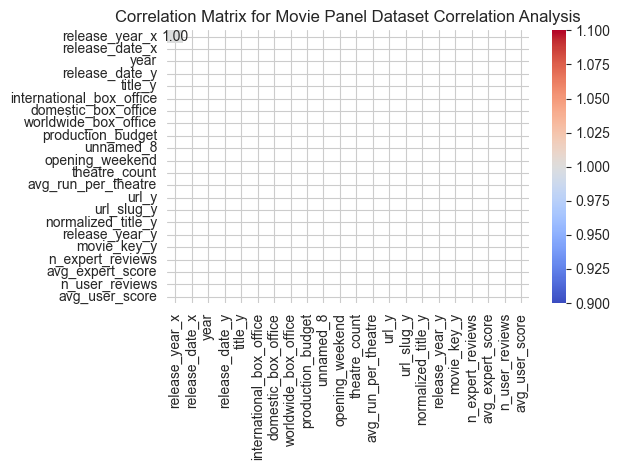

In [69]:
#Correlation matrix for all 4 datasets
def correlation_matrix(df, title):
    print(f"\nCorrelation matrix for {title}:")

    #Select only numeric columns
    df_numeric = df.select_dtypes(include=(np.number))
    correlation_matrix = df_numeric.corr()
    print(correlation_matrix.round(2))

    #Highlight strong correlations
    strong_correlation = correlation_matrix[(correlation_matrix >= 0.7) | (correlation_matrix <= -0.7)]
    print("\nStrong Correlations (>= |0.7|):")
    print(strong_correlation.dropna(how='all', axis=0).dropna(how='all', axis=1).round(2))

    #Plot heatmaps
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"Correlation Matrix for {title}")
    plt.tight_layout()
    plt.show()

#Feature Engineering for movie panel dataset
movie_panel_full_for_correlation_check = movie_panel_full.copy()

#Define columns for encoding
encoding_columns = ['studio', 'primary_genre', 'rating']

movie_panel_full_for_correlation_check = pd.get_dummies(
    movie_panel_full_for_correlation_check,
    columns=encoding_columns,
    drop_first=True
)

#Run correlation analysis
correlation_matrix(movie_panel_full_for_correlation_check, "Movie Panel Dataset Correlation Analysis")

# 1.9 Distribution plots (Iro)

In [71]:
def plot_numeric_distributions(df, title="Distribution of Numeric Columns", n_cols=3):
    
    # Select numeric columns
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Remove unnamed columns
    num_cols = [col for col in num_cols if not col.lower().startswith("unnamed")]
    
    # Remove constant-value columns (no real distribution)
    num_cols = [col for col in num_cols if df[col].nunique() > 1]
    
    if len(num_cols) == 0:
        print("No numeric columns left to plot.")
        return
    
    n_rows = int(np.ceil(len(num_cols) / n_cols))
    
    plt.figure(figsize=(9, 2.2 * n_rows))  # compact layout
    
    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[col], kde=True, bins=20)
        plt.title(col, fontsize=9, ha="center")
        plt.xlabel("")
        plt.ylabel("")
    
    plt.suptitle(title, fontsize=12, y=1.02, ha="center")
    plt.tight_layout(pad=1.0)
    plt.show()


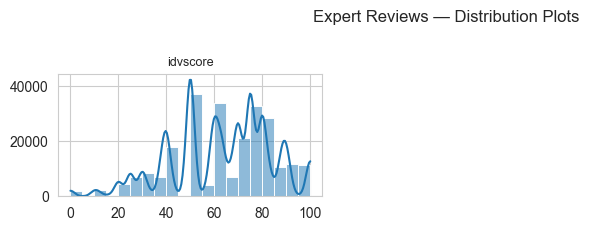

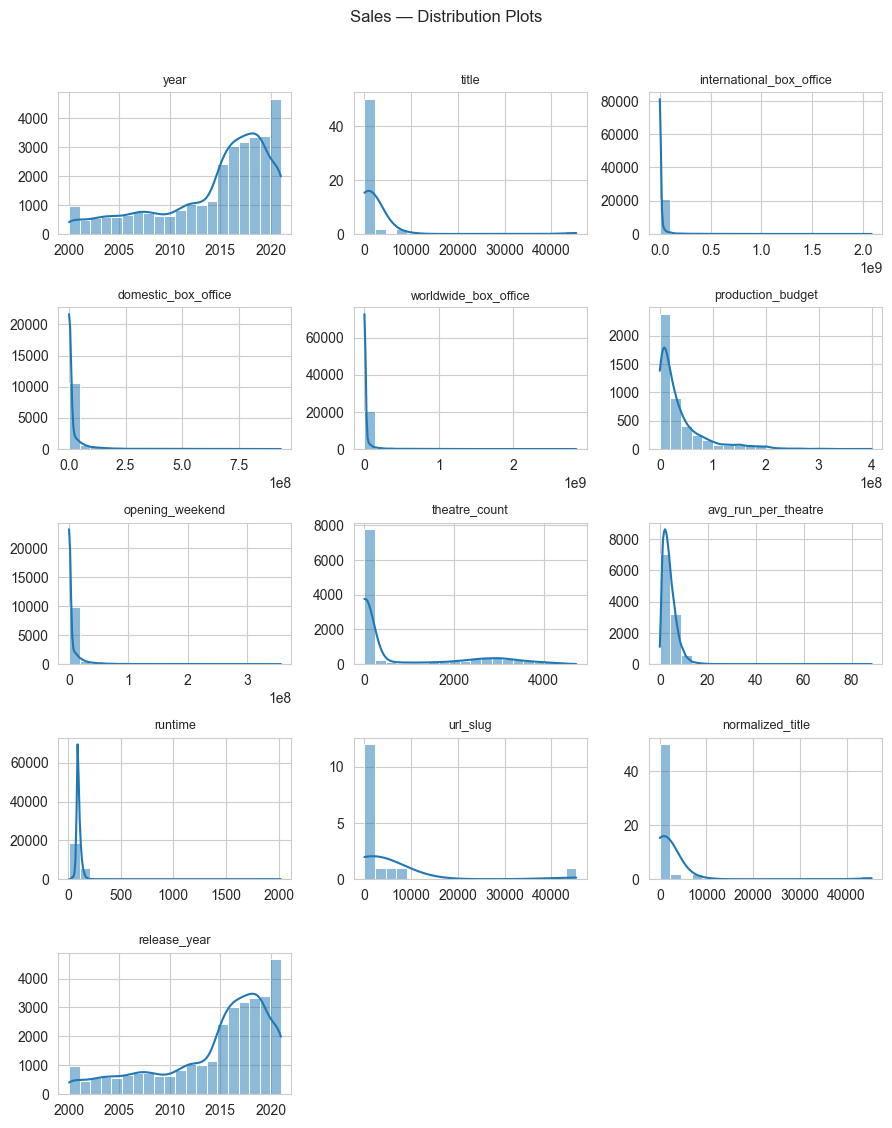

In [72]:
plot_numeric_distributions(df_exreviews, title="Expert Reviews — Distribution Plots")
plot_numeric_distributions(df_sales, title="Sales — Distribution Plots")

For user reviews there are no numeric values to plot.

# Chapter 2 Feature Engineering (Iro)

**ML Feature Dataset Construction**

To support supervised learning, a new feature dataset X_movies was created without overwriting existing relational tables. This dataset contains one row per movie_id and serves as the direct input to machine learning models.

Existing normalized/relational sources:
- movies_master
- movie_panel_full
- df_exreviews
- df_usreviews
- genre_table
- actor_table
- cast_table
- df_sales

These tables are designed for data storage, normalization, and integrity, not for direct modeling.

**Model requirements:**
- X (features): a fixed-size, fully numeric feature matrix
- y (target): one outcome value per movie

**Why movie_panel_full is not ML-ready:**  
Although comprehensive, movie_panel_full:
- contains categorical strings and identifiers
- includes missing values
- lacks semantic text representations (embeddings)
- has no dimensionality reduction
- mixes storage-oriented and modeling-oriented attributes

Therefore, X_movies was constructed through feature engineering, encoding, scaling, embedding extraction, and feature selection to produce a clean, model-ready dataset.

## 2.1. Apply column removals

In [87]:
# create ML-ready feature base table from movie_panel_full

movie_fe_base = movie_panel_full.copy()

# if the merged table still has release_year_x, normalize the name
if "release_year_x" in movie_fe_base.columns and "release_year" not in movie_fe_base.columns:
    movie_fe_base = movie_fe_base.rename(columns={"release_year_x": "release_year"})

# keep only columns that are valid model features (plus movie_id)
feature_cols = [
    "movie_id",
    "release_year",
    "studio",
    "director",
    "domestic_box_office",
    "international_box_office",
    "worldwide_box_office",
    "production_budget",
    "opening_weekend",
    "theatre_count",
    "n_expert_reviews",
    "avg_expert_score",
    "n_user_reviews",
    "avg_user_score",
]

# select only columns that exist 
feature_cols = [c for c in feature_cols if c in movie_fe_base.columns]
movie_fe_base = movie_fe_base[feature_cols].copy()


Columns were removed if they exhibited data leakage, high sparsity, or redundancy identified during EDA. This ensures that retained features contribute meaningful, non-duplicative information to the learning algorithms.

In [88]:
#movie_fe_base.head(5)

## 2.2. Transformers - BERT embeddings via Hugging Face transformers

#### Motivation for transformer-based feature extraction

Textual movie reviews contain semantic information, such as nuanced opinions, contextual judgments, and comparative language, that cannot be effectively captured using traditional bag-of-words representations or simple sentiment scores. To incorporate this information into the feature set, transformer-based embeddings were selected due to their ability to model contextual meaning.

Expert reviews were used exclusively for this purpose, as they tend to be more structured, consistent, and information-dense than user reviews. This makes them particularly suitable for contextual language models such as BERT, allowing the extraction of reliable semantic representations without requiring task-specific fine-tuning.


In [89]:
# !pip install transformers sentence-transformers

In [90]:
import torch
from transformers import AutoTokenizer, AutoModel

Load bert 

In [91]:
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

Encode texts (batching)


In [92]:
def bert_embed_texts(texts, tokenizer, model, batch_size=32, max_length=256, pooling="cls"):
    all_vecs = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )
            out = model(**enc)  # last_hidden_state: [B, T, H]
            last_hidden = out.last_hidden_state

            if pooling == "cls":
                vecs = last_hidden[:, 0, :]  # [CLS]
            elif pooling == "mean":
                mask = enc["attention_mask"].unsqueeze(-1)  # [B, T, 1]
                summed = (last_hidden * mask).sum(dim=1)
                counts = mask.sum(dim=1).clamp(min=1)
                vecs = summed / counts
            else:
                raise ValueError("pooling must be 'cls' or 'mean'")

            all_vecs.append(vecs.cpu().numpy())

    return np.vstack(all_vecs)


Apply to review text and aggregate to movie level

Transformer Feature Engineering: 
- Raw expert review text is first cleaned and standardized during preprocessing.
- A Hugging Face transformer model (Sentence-BERT) is then used to convert each review into a dense semantic embedding vector.
- These embeddings capture context and meaning beyond simple word counts.
- Since models operate at the movie level, review-level embeddings are aggregated by movie_id using mean pooling.
- The resulting high-dimensional embedding features are reduced using PCA to remove noise and prevent overfitting.
- PCA components are combined with structured numeric features to form the final ML feature matrix.
- This matrix is then used as input for supervised learning models.

In [93]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [95]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

# keep  existing preprocessing
review_text_df = (
    df_exreviews[["movie_id", "rev"]]
    .dropna(subset=["rev"])
    .reset_index(drop=True)
)

texts = (
    review_text_df["rev"]
    .astype(str)
    .str.slice(0, 500)   # truncate for speed
    .tolist()
)

# fast Hugging Face model (BERT-derived)
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# encode 
emb = model.encode(
    texts,
    batch_size=128,          # ↑ big batch = speed
    show_progress_bar=True,
    convert_to_numpy=True
)

# build embedding dataframe
emb_cols = [f"emb_{i}" for i in range(emb.shape[1])]
review_emb_df = pd.DataFrame(emb, columns=emb_cols)
review_emb_df["movie_id"] = review_text_df["movie_id"].values

# aggregate to movie level (unchanged)
movie_emb_df = (
    review_emb_df
    .groupby("movie_id")[emb_cols]
    .mean()
    .reset_index()
)

# merge into feature base
X_with_emb = movie_fe_base.merge(movie_emb_df, on="movie_id", how="left")
X_with_emb[emb_cols] = X_with_emb[emb_cols].fillna(0.0)


Batches: 100%|██████████| 1929/1929 [04:33<00:00,  7.05it/s]


#### Outcome of transformer-based feature extraction

A pre-trained transformer model from the Hugging Face repository was used to extract dense semantic embeddings from expert review text. Review-level embeddings were aggregated at the movie level using mean pooling, resulting in fixed-length numerical representations for each movie. Expert reviews were used exclusively, as they provide richer and more consistent semantic information than user reviews. These embeddings preserve semantic information relevant to movie reception and are directly compatible with the supervised learning models used in subsequent stages.


## 2.3. PCA on embeddings, scaling, encoding → final X_movies

In [96]:
# identify embedding columns in X_with_emb
emb_cols = [c for c in X_with_emb.columns if c.startswith("emb_")]
len(emb_cols), emb_cols[:5]

(384, ['emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4'])

#### Rationale for dimensionality reduction

The transformer-based embeddings consist of 384 numerical features per movie, derived from a pre-trained Hugging Face model. While these embeddings encode rich semantic information, their high dimensionality increases the risk of redundancy, noise, and overfitting. As the embeddings are continuous and numerical, they are well suited for matrix decomposition techniques such as Principal Component Analysis (PCA) or Truncated Singular Value Decomposition (SVD).


Numerical features were scaled to ensure comparable magnitude across inputs, while categorical variables were encoded to enable model compatibility. Due to the high dimensionality of the transformer-based embeddings, dimensionality reduction was applied prior to model training to reduce noise, improve generalization, and limit computational cost.

## 2.4. Apply PCA (matrix decomposition) to embeddings (feature selection)

In [ ]:
from sklearn.decomposition import PCA

N_COMPONENTS = 50  # typical: 25–100

pca = PCA(n_components=N_COMPONENTS, random_state=42)

emb_pca = pca.fit_transform(X_with_emb[emb_cols].values)

pca_cols = [f"emb_pca_{i+1}" for i in range(N_COMPONENTS)]
emb_pca_df = pd.DataFrame(emb_pca, columns=pca_cols, index=X_with_emb.index)

# replace raw embeddings with PCA components
X_pca = pd.concat(
    [X_with_emb.drop(columns=emb_cols), emb_pca_df],
    axis=1
)

# report variance explained
explained_var = pca.explained_variance_ratio_.sum()
explained_var


np.float32(0.81494176)

Principal Component Analysis (PCA) was applied as a matrix decomposition method to perform feature selection on the embedding space. Components were retained to preserve the majority of explained variance, ensuring that semantic information from reviews was maintained while removing redundant dimensions. This step directly addresses the curse of dimensionality introduced by transformer embeddings.

## 2.5. Build preprocessing: scale numeric and encode categorical

In [98]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# build preprocessing: scale numeric + encode categorical
# choose which categorical columns you want to encode
cat_cols = [c for c in ["studio"] if c in X_pca.columns]   

# numeric columns = all numeric non-ID, non-categorical, non-text columns + PCA components
# exclude movie_id and categorical vars, keep only numeric dtype
base_num_cols = [
    c for c in X_pca.columns
    if c not in (["movie_id"] + cat_cols)
    and (pd.api.types.is_numeric_dtype(X_pca[c]))
]

# ensure PCA cols are included (they should already be numeric, but this is to be safe)
num_cols = list(dict.fromkeys(base_num_cols + pca_cols))  # de-duplicate while preserving order

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        # sklearn >= 1.2 uses sparse_output instead of sparse
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop"
)

# produce final ML-ready feature matrix X_movies
X_matrix = preprocessor.fit_transform(X_pca)

# build readable column names
cat_feature_names = []
if len(cat_cols) > 0:
    ohe = preprocessor.named_transformers_["cat"]
    cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()

final_feature_names = num_cols + cat_feature_names

X_movies = pd.DataFrame(X_matrix, columns=final_feature_names)
X_movies.insert(0, "movie_id", X_pca["movie_id"].values)

# quick checks
print("X_movies shape:", X_movies.shape)
X_movies.head()

X_movies shape: (33772, 1180)


,movie_id,release_year,domestic_box_office,international_box_office,worldwide_box_office,production_budget,opening_weekend,theatre_count,n_expert_reviews,avg_expert_score,...,studio_Zeitgeist Films,studio_Zenpix,studio_Zipporah Films,studio_eFilm Studios,studio_erbp,studio_levelFILM,studio_mTuckman Media,studio_myCinema,studio_nWave Pictures,studio_nan
0,MOV00001,-0.598648,-0.342558,NaN,NaN,NaN,-0.335727,-0.578696,-1.339523,-0.155112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MOV00002,0.290566,1.083212,0.305165,0.821812,-0.461202,1.177669,2.140146,2.388009,0.930784,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MOV00003,-1.487861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MOV00004,-0.420805,-0.339569,-0.226444,-0.240301,NaN,-0.334692,-0.577894,-0.221263,-0.009819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MOV00005,-0.242962,-0.343474,NaN,NaN,NaN,-0.335873,-0.569871,-0.687205,0.207470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Key takeaways of the final table 

- Numeric features were standardized (z-score normalization)
- Negative values indicate observations below the dataset mean
- Positive values indicate observations above the dataset mean
- Values near zero represent average movies
- Missing values remain as NaN prior to imputation
- High column count is due to one-hot encoding of studios
- Transformer embeddings were dimension-reduced using PCA
- Final dataset contains only numeric, model-ready features


This preprocessing pipeline ensures reproducibility and consistent transformation between training and inference stages.

In [99]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_movies_imputed = X_movies.copy()

feature_cols = X_movies_imputed.columns.drop("movie_id")
X_movies_imputed[feature_cols] = imputer.fit_transform(
    X_movies_imputed[feature_cols]
)

Numeric features were standardized using z-score normalization, resulting in negative values for observations below the dataset mean.

After completing exploratory analysis, feature engineering, transformer-based embedding extraction, and dimensionality reduction via PCA, we proceeded to generate training, validation, and test datasets

# Test

In [ ]:
#Test number 2
#Test number 3